## Assessing base quality and indels falling on reads with T putative (CT context region)
In this notebook I will analyse the distribution of Basecalling Quality of bases in reads calling for a T in a CT context in WT and KO samples to understand if this could be a good discriminator to distinguish among putative and real T called base. This is because I noted that, in KO sample, T bases called in a CT context (C-to-U sites called by Ernesto) seems to have I lower basecalling quality value with respect the WT ones.

In [1]:
# importing basic modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pysam

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [2]:
# IMPLEMENTING THE BASECALLING FEATURE RETRIEVING

def retrieve_basecalling_tables(bam_file, contig, site_0_based):
    region_seqs = []
    region_quals = []
    region_qnames = []
    for pileupcolumn in bam_file.pileup(contig, site_0_based-4, site_0_based+4, truncate=True, max_depth=1000000, min_base_quality=0):
        region_seqs.append(pileupcolumn.get_query_sequences(mark_matches=True, add_indels=True))
        region_qnames.append(pileupcolumn.get_query_names())
        region_quals.append(pileupcolumn.get_query_qualities())
    
    # extract called bases
    region_df_seqs = []
    region_df_quals = []
    for n, s in zip(region_qnames, region_seqs):
        region_df_seqs.append(pd.DataFrame(s, index=n))
    try:
        region_df_seqs = pd.concat(region_df_seqs, axis=1)
        region_df_seqs.columns = list(range(site_0_based-3, site_0_based+5)) # columns in format 1-based

        # extract insertions
        region_df_ins = region_df_seqs.copy()
        region_df_ins.columns = region_df_ins.columns + 1
        region_df_ins.drop(columns=region_df_ins.columns[-1], inplace=True)
        region_df_ins = region_df_ins.applymap(lambda x: np.nan if not pd.notnull(x) else 1 if ("+" in x) else 0)

        # drop the first column-position in region_df_seqs used only for insertion calculation
        region_df_seqs.drop(columns=region_df_seqs.columns[0], inplace=True)

        # eliminate +/- terms if present for each position into region_df_seqs
        region_df_seqs = region_df_seqs.applymap(lambda x: x[0] if pd.notnull(x) else np.nan)

        # extract qualities
        for n, s in zip(region_qnames, region_quals):
            region_df_quals.append(pd.DataFrame(s, index=n))
        region_df_quals = pd.concat(region_df_quals, axis=1)
        region_df_quals.columns = list(range(site_0_based-3, site_0_based+5)) # coluns in format 1-based
        region_df_quals.drop(columns=region_df_quals.columns[0], inplace=True)

        # let's eliminates quality scores for reads and positions with deletion
        region_df_quals = region_df_quals - region_df_quals[(region_df_seqs == "*")].fillna(0)
        region_df_quals.replace(0, pd.NA, inplace=True)
        return region_df_seqs, region_df_ins, region_df_quals
    except:
        return pd.DataFrame([]), pd.DataFrame([]), pd.DataFrame([])

    
def depth_at_position(bam_file, contig, position_1_based):
    '''
    calculate by pysam depth of coverage at a given position subtracted by deletions (as IGV broswer).
    '''
    counter = 0
    pos_0_based = position_1_based - 1
    for pileupcolumn in bam_file.pileup(contig, pos_0_based, pos_0_based+1, truncate=True, max_depth=1000000, min_base_quality=0):
        counter += 1
        col = pileupcolumn.get_query_sequences(mark_matches=True, add_indels=True)
        depth_with_dels = len(col)
        dels = col.count("*")
        depth = depth_with_dels - dels
    if counter == 0:
        depth = 0
    return depth

In [3]:
# defining paths to files
wt_bam_path = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/wt.bam"
ko_bam_path = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/ko.bam"
ref_path = "/lustre/bio_running/C_to_U_editing/refs/GRCm39.primary_assembly.genome.fa"

In [4]:
# opening edited site called by Ernesto with Illumina runs
columns = pd.read_table("/lustre/bio_running/C_to_U_editing/merged_mm39_columns.txt", header=None).T.values[0].tolist()
ed_sites = pd.read_table("/lustre/bio_running/C_to_U_editing/merged_mm39.tsv", header=None)
ed_sites.columns = columns
ed_sites

contig_mm39   pos_mm39 contig_mm10   pos_mm10 ref_base  strand  cov_WT  \
0          chr1    4915683        chr1    4845460        C       1     290   
1          chr1    4915694        chr1    4845471        C       1     290   
2          chr1    4915851        chr1    4845628        C       1     142   
3          chr1    4916384        chr1    4846161        C       1     183   
4          chr1    4967044        chr1    4896821        C       1     439   
..          ...        ...         ...        ...      ...     ...     ...   
682        chrX  166129481        chrX  167346485        C       0     125   
683        chrX  166130959        chrX  167347963        C       0      70   
684        chrX  166131073        chrX  167348077        C       0     116   
685        chrX  166131296        chrX  167348300        C       0     133   
686        chrX  166131328        chrX  167348332        C       0      94   

     MeanQual_WT BaseCount_WT[A,C,G,T] Subs_WT  SubsFreq_WT  cov_KO  \
0          35.40       [0, 258, 0, 32]      CT         0.11     184   
1          35.45       [0, 258, 0, 32]      CT         0.11     183   
2          35.19        [0, 135, 0, 7]      CT         0.05      83   
3          35.79       [0, 164, 0, 19]      CT         0.10     134   
4          35.51       [0, 404, 0, 35]      CT         0.08     325   
..           ...                   ...     ...          ...     ...   
682        35.35        [0, 119, 0, 6]      CT         0.05      86   
683        35.71         [0, 66, 0, 4]      CT         0.06      70   
684        35.45        [0, 110, 0, 6]      CT         0.05     128   
685        35.46       [0, 120, 0, 13]      CT         0.10     102   
686        35.18         [0, 87, 0, 7]      CT         0.07      90   

     MeanQual_KO BaseCount_KO[A,C,G,T] Subs_KO  SubsFreq_KO  \
0          35.08        [0, 184, 0, 0]       -          0.0   
1          35.54        [0, 183, 0, 0]       -          0.0   
2          35.00         [0, 83, 0, 0]       -          0.0   
3          35.85        [0, 134, 0, 0]       -          0.0   
4          35.56        [0, 325, 0, 0]       -          0.0   
..           ...                   ...     ...          ...   
682        35.72         [0, 86, 0, 0]       -          0.0   
683        35.58         [0, 70, 0, 0]       -          0.0   
684        35.77        [0, 128, 0, 0]       -          0.0   
685        35.44        [0, 102, 0, 0]       -          0.0   
686        35.16         [0, 90, 0, 0]       -          0.0   

    PositionAnnotation gene_name  
0                 UTR3    Lypla1  
1                 UTR3    Lypla1  
2                 UTR3    Lypla1  
3                 UTR3    Lypla1  
4                 UTR3     Tcea1  
..                 ...       ...  
682               UTR3     Prps2  
683               UTR3     Prps2  
684               UTR3     Prps2  
685               UTR3     Prps2  
686               UTR3     Prps2  

[687 rows x 18 columns]

In [5]:
# open reference file
ref = pysam.Fastafile(ref_path)

# open bam files
wt_bam = pysam.AlignmentFile(wt_bam_path)
ko_bam = pysam.AlignmentFile(ko_bam_path)

In [6]:
# retrieve for each CT site the quality of bases on reads calling a T mismatches only forward strand

WT_T_qual = [] # where to store the quality of T base mapping on the site (CT context) for WT samples
KO_T_qual = [] # where to store the quality of T base mapping on the site (CT context) for KO samples
WT_region_mean_qual = [] # where to store the mean quality of region +/- 3 nt around the site (CT context) for WT samples
KO_region_mean_qual = [] # where to store the mean quality of region +/- 3 nt around the site (CT context) for KO samples
WT_region_ins = [] # where to store the insertion count of region +/- 3 around the site (CT context) for WT samples
KO_region_ins = [] # where to store the insertion count of region +/- 3 around the site (CT context) for KO samples
WT_region_mism = [] # where to store the mismatches count of region +/- 3 around the site (CT context) for WT samples
KO_region_mism = [] # where to store the mismatches count of region +/- 3 around the site (CT context) for KO samples
WT_region_dels = [] # where to store the deletion count of region +/- 3 around the site (CT context) for WT samples
KO_region_dels = [] # where to store the deletion count of region +/- 3 around the site (CT context) for KO samples
WT_ref_contexts = [] # where to store reference cotext (5-mers where the central base is the putative edited site) for WT reads.
KO_ref_contexts = [] # where to store reference cotext (5-mers where the central base is the putative edited site) for KO reads.
WT_readnames = [] # where to store the readname of retrieved regions +/- 3 around the site (CT context) for WT samples
KO_readnames = [] # where to store the readname of retrieved regions +/- 3 around the site (CT context) for KO samples
WT_sitecoords = [] # where to store the coordinates of retrieved regions +/- 3 around the site (CT context) for WT samples
KO_sitecoords = [] # where to store the coordinates of retrieved regions +/- 3 around the site (CT context) for KO samples

for site in ed_sites[ed_sites["strand"] == 1].itertuples():
    print("###################################################################################################")
    print(site[1], site[2], "- WT Illumina Subs:", site[9], "KO Illumina Subs:", site[14]) # 1 based
    ref_context = np.array(list(ref.fetch(site[1], site[2]-4, site[2]+3)))
    print(ref_context)
    
    # WT
    print("WT")
    # retrieve all reads for the whole region -3/+3
    region_df_seqs, region_df_ins, region_df_quals = retrieve_basecalling_tables(wt_bam, site[1], site[2]-1)
    
    # assess that at least one read is aligned on the requested position
    if not region_df_seqs.empty:
        # select only reads with a T on the central position
        Tseq = region_df_seqs[region_df_seqs.iloc[:,3] == "T"]
        Tqual = region_df_quals.loc[Tseq.index]
        Tins = region_df_ins.loc[Tseq.index]

        for read in Tseq.itertuples():
            print("\n", read[0])
            m = ref_context == np.array(read[1:])
            m = m[m==False].shape[0] - region_df_seqs.loc[read[0]].tolist().count("*") # minus the number of deletions
            print("Mismatches:", m)
            print("T qual:", Tqual.loc[read[0]].iloc[3])
            print("Region mean qual:", Tqual.loc[read[0]].mean())
            print("Region ins count:", Tins.loc[read[0]].sum())
            print("Region dels count:", region_df_seqs.loc[read[0]].tolist().count("*"))
            WT_ref_contexts.append("".join(ref_context[1:-1].tolist()))
            curr_site = f"{site[1]}:{site[2]}"
            WT_sitecoords.append(curr_site)
            WT_readnames.append(read[0]) # append readname current read
            WT_region_mism.append(m) # append mismatches count on region of current read
            WT_T_qual.append(Tqual.loc[read[0]].iloc[3]) # append T central quality mean of current read
            WT_region_mean_qual.append(Tqual.loc[read[0]].mean()) # append mean quality for region on current read
            WT_region_ins.append(Tins.loc[read[0]].sum()) # append insertion count for region on current read
            WT_region_dels.append(region_df_seqs.loc[read[0]].tolist().count("*"))
    
    # KO
    print()
    print("KO")
     # retrieve all reads for the whole region -3/+3
    region_df_seqs, region_df_ins, region_df_quals = retrieve_basecalling_tables(ko_bam, site[1], site[2]-1)
    
    # assess that at least one read is aligned on the requested position
    if not region_df_seqs.empty:
        # select only reads with a T on the central position
        Tseq = region_df_seqs[region_df_seqs.iloc[:,3] == "T"]
        Tqual = region_df_quals.loc[Tseq.index]
        Tins = region_df_ins.loc[Tseq.index]

        for read in Tseq.itertuples():
            print("\n", read[0])
            m = ref_context == np.array(read[1:])
            m = m[m==False].shape[0] - region_df_seqs.loc[read[0]].tolist().count("*") # minus the number of deletions
            print("Mismatches:", m)
            print("T qual:", Tqual.loc[read[0]].iloc[3])
            print("Region mean qual:", Tqual.loc[read[0]].mean())
            print("Region ins count:", Tins.loc[read[0]].sum())
            print("Region dels count:", region_df_seqs.loc[read[0]].tolist().count("*"))
            KO_ref_contexts.append("".join(ref_context[1:-1].tolist()))
            curr_site = f"{site[1]}:{site[2]}"
            KO_sitecoords.append(curr_site)
            KO_readnames.append(read[0]) # append readname current read
            KO_region_mism.append(m)  # append mismatches count on region of current read
            KO_T_qual.append(Tqual.loc[read[0]].iloc[3]) # append T central quality mean of current read
            KO_region_mean_qual.append(Tqual.loc[read[0]].mean()) # append mean quality for region on current read
            KO_region_ins.append(Tins.loc[read[0]].sum()) # append insertion count for region on current read
            KO_region_dels.append(region_df_seqs.loc[read[0]].tolist().count("*"))

###################################################################################################
chr1 4915683 - WT Illumina Subs: [0, 258, 0, 32] KO Illumina Subs: [0, 184, 0, 0]
['T' 'C' 'A' 'C' 'A' 'T' 'A']
WT

 ecdf0e3c-0faa-4ea2-baac-5d9ea7f94379
Mismatches: 1
T qual: 11.0
Region mean qual: 15.571428571428571
Region ins count: 0
Region dels count: 0

 0a99a6af-e051-4615-ba7a-adc0e0fe6883
Mismatches: 1
T qual: 16.0
Region mean qual: 18.571428571428573
Region ins count: 0
Region dels count: 0

 46e4d1cf-073f-4115-b926-1254aa71ecd1
Mismatches: 1
T qual: 3.0
Region mean qual: 5.4
Region ins count: 0
Region dels count: 2

 b8400ebf-14f4-4cc0-9bc3-fcc2b8cf2208
Mismatches: 1
T qual: 5.0
Region mean qual: 7.8
Region ins count: 0
Region dels count: 2

 1b3e712c-fec8-426f-b767-884e739734a7
Mismatches: 3
T qual: 11.0
Region mean qual: 12.857142857142858
Region ins count: 0
Region dels count: 0

 b69c759f-cd73-40a9-bc6b-5e2c0e776c93
Mismatches: 2
T qual: 9.0
Region mean qual: 10.0
Region in


 56a3cde5-e84b-4bf0-82d9-eb86556046de
Mismatches: 1
T qual: 5.0
Region mean qual: 13.8
Region ins count: 0
Region dels count: 2

 4c1dfe58-998a-43e5-bf1b-47d37d835710
Mismatches: 1
T qual: 8.0
Region mean qual: 13.285714285714286
Region ins count: 0
Region dels count: 0

 3bbb7819-bed2-4927-a473-2c404c1c80a9
Mismatches: 4
T qual: 6.0
Region mean qual: 8.571428571428571
Region ins count: 0
Region dels count: 0

 e3028feb-3eaa-4bc2-8c5b-2023ed4cff16
Mismatches: 4
T qual: 10.0
Region mean qual: 12.0
Region ins count: 0
Region dels count: 0

 ec09fae8-ddd6-4aba-8009-9dd7a9dafba6
Mismatches: 2
T qual: 4.0
Region mean qual: 9.2
Region ins count: 0
Region dels count: 2
###################################################################################################
chr1 39410802 - WT Illumina Subs: [0, 122, 0, 9] KO Illumina Subs: [0, 59, 0, 0]
['T' 'A' 'A' 'C' 'T' 'T' 'A']
WT

 0f4e4e6a-81b0-4114-afc6-7e023d1e0a9a
Mismatches: 1
T qual: 4.0
Region mean qual: 16.333333333333332
Region ins c


 f1bdc444-f26b-47ad-9f0b-11cf3cef76de
Mismatches: 1
T qual: 4.0
Region mean qual: 12.0
Region ins count: 0.0
Region dels count: 1

 1c7850f4-6ac5-4246-a661-f93182017184
Mismatches: 1
T qual: 13.0
Region mean qual: 13.5
Region ins count: 0.0
Region dels count: 1
###################################################################################################
chr1 82873539 - WT Illumina Subs: [0, 83, 0, 11] KO Illumina Subs: [0, 74, 0, 0]
['A' 'A' 'A' 'C' 'T' 'A' 'C']
WT

 3156dade-4313-4e52-bf46-4f15c6d58272
Mismatches: 2
T qual: 25.0
Region mean qual: 16.0
Region ins count: 1
Region dels count: 0

KO
###################################################################################################
chr1 93435866 - WT Illumina Subs: [0, 515, 0, 29] KO Illumina Subs: [0, 392, 0, 0]
['G' 'T' 'A' 'C' 'T' 'C' 'T']
WT

 fcd6f860-45a1-4aa9-8379-e5de1674a4e3
Mismatches: 2
T qual: 8.0
Region mean qual: 13.571428571428571
Region ins count: 1
Region dels count: 0

 c21f43c7-18f0-4b7e-98b2-ebd9

###################################################################################################
chr2 71732295 - WT Illumina Subs: [0, 160, 0, 10] KO Illumina Subs: [0, 136, 0, 0]
['G' 'T' 'A' 'C' 'A' 'A' 'C']
WT

 e32feec8-26e0-4ed9-901a-4d39be1df5bc
Mismatches: 2
T qual: 7.0
Region mean qual: 9.428571428571429
Region ins count: 0
Region dels count: 0

 df2d09de-87b3-4074-a8e3-fbe9ff0cf3b7
Mismatches: 1
T qual: 12.0
Region mean qual: 16.857142857142858
Region ins count: 0
Region dels count: 0

KO

 fe4cc575-0fe1-4429-b2fc-c7697836ddb9
Mismatches: 2
T qual: 4.0
Region mean qual: 17.142857142857142
Region ins count: 0
Region dels count: 0

 6a68f47a-072f-4f0e-9b3b-a1e8ddd24dc3
Mismatches: 1
T qual: 3.0
Region mean qual: 7.0
Region ins count: 1
Region dels count: 0
###################################################################################################
chr2 79159062 - WT Illumina Subs: [0, 251, 0, 31] KO Illumina Subs: [0, 156, 0, 0]
['A' 'A' 'A' 'C' 'T' 'T' 'A']
WT

 57528


 e9b92099-d493-4eeb-8a89-3350f05e373d
Mismatches: 1
T qual: 5.0
Region mean qual: 13.428571428571429
Region ins count: 0.0
Region dels count: 0

 3ed6203e-9db0-4254-a28f-d26035d1d739
Mismatches: 2
T qual: 3.0
Region mean qual: 7.2
Region ins count: 0.0
Region dels count: 2

 5f96550b-9685-408e-8dd0-22f234f769e1
Mismatches: 4
T qual: 3.0
Region mean qual: 11.714285714285714
Region ins count: 0.0
Region dels count: 0

 78798239-aba6-45fe-89fb-402ee117d086
Mismatches: 2
T qual: 11.0
Region mean qual: 9.285714285714286
Region ins count: 2.0
Region dels count: 0

 c869cc30-d40a-4f18-a314-1de0cd1e1cea
Mismatches: 1
T qual: 12.0
Region mean qual: 9.2
Region ins count: 1.0
Region dels count: 2

 fdffe2bd-2c3b-4b69-b22d-3275287b9f8d
Mismatches: 3
T qual: 3.0
Region mean qual: 10.0
Region ins count: 0.0
Region dels count: 0

 7c40115c-09fa-481a-8851-7e61c42717f0
Mismatches: 3
T qual: 2.0
Region mean qual: 9.714285714285714
Region ins count: 0.0
Region dels count: 0

 4fd42e9e-9746-46f8-8d9c-a24

 beb3d810-0e8a-451e-b51c-690145a1749e
Mismatches: 1
T qual: 33.0
Region mean qual: 24.571428571428573
Region ins count: 0.0
Region dels count: 0

 45c23c72-8433-4c64-9c51-41580a448dd0
Mismatches: 1
T qual: 22.0
Region mean qual: 17.142857142857142
Region ins count: 0.0
Region dels count: 0

 f5167782-00dd-4e3b-866b-dcbff27cf67a
Mismatches: 1
T qual: 32.0
Region mean qual: 25.714285714285715
Region ins count: 0.0
Region dels count: 0

 c1a73cda-5431-43f6-a3aa-a0265f8d8938
Mismatches: 1
T qual: 14.0
Region mean qual: 19.142857142857142
Region ins count: 0.0
Region dels count: 0

 ce6599a5-c5c3-48b9-bea2-8286f6fa1a49
Mismatches: 1
T qual: 15.0
Region mean qual: 16.428571428571427
Region ins count: 0.0
Region dels count: 0

 fe2f165b-f147-48d1-a489-f281ff69acf5
Mismatches: 1
T qual: 11.0
Region mean qual: 10.142857142857142
Region ins count: 0.0
Region dels count: 0

 98be9e65-86b2-45bb-84c3-888b0ac9d0a5
Mismatches: 1
T qual: 26.0
Region mean qual: 21.714285714285715
Region ins count: 0.0


Region ins count: 0.0
Region dels count: 0

 0d9c075a-ce26-4745-87de-f40069ef2b5d
Mismatches: 1
T qual: 24.0
Region mean qual: 25.571428571428573
Region ins count: 0.0
Region dels count: 0

 084c281f-ab35-42f1-8b2f-800b2e1f3f3d
Mismatches: 2
T qual: 3.0
Region mean qual: 7.571428571428571
Region ins count: 0.0
Region dels count: 0

 3a9e1a16-4a31-484c-9703-0cb1d1b56c58
Mismatches: 2
T qual: 11.0
Region mean qual: 11.142857142857142
Region ins count: 0.0
Region dels count: 0

 3e631935-b68a-420c-8f67-1c9db02a1f2a
Mismatches: 1
T qual: 29.0
Region mean qual: 29.142857142857142
Region ins count: 0.0
Region dels count: 0

 79ba9c2c-2406-4e13-a1c1-1e77934e6c54
Mismatches: 1
T qual: 26.0
Region mean qual: 20.142857142857142
Region ins count: 0.0
Region dels count: 0

 d3e04463-ff34-4c3b-975e-0086d98c4633
Mismatches: 1
T qual: 26.0
Region mean qual: 27.428571428571427
Region ins count: 0.0
Region dels count: 0

 6689b3ea-1a43-4e0b-b5e6-9f7b6a1bde2f
Mismatches: 1
T qual: 27.0
Region mean qual:

Region ins count: 0.0
Region dels count: 1

 d2df4060-45a9-449b-b390-312a22f5b9ab
Mismatches: 2
T qual: 17.0
Region mean qual: 13.428571428571429
Region ins count: 0.0
Region dels count: 0

 a55bd5de-ae43-4938-872b-3885ad9bf616
Mismatches: 2
T qual: 19.0
Region mean qual: 13.714285714285714
Region ins count: 0.0
Region dels count: 0

 0ed1a81c-4433-42e5-8742-b230cffa8032
Mismatches: 2
T qual: 25.0
Region mean qual: 24.714285714285715
Region ins count: 0.0
Region dels count: 0

 5a59cbca-6c76-4c1b-9cc5-bcf12086976f
Mismatches: 1
T qual: 20.0
Region mean qual: 13.857142857142858
Region ins count: 0.0
Region dels count: 0

 c2a7d666-c06e-4cc8-8c0f-f6458e4dd15e
Mismatches: 1
T qual: 28.0
Region mean qual: 27.0
Region ins count: 0.0
Region dels count: 0

 0cb7606f-db37-4cfa-9069-3bc4daa237be
Mismatches: 1
T qual: 31.0
Region mean qual: 26.571428571428573
Region ins count: 0.0
Region dels count: 0

 338e6a1a-caab-47ec-aab5-75e46128ad9c
Mismatches: 1
T qual: 7.0
Region mean qual: 6.5714285714


 3bd057de-02bc-433b-adb4-4f3816ecd500
Mismatches: 2
T qual: 31.0
Region mean qual: 21.571428571428573
Region ins count: 0.0
Region dels count: 0

 de8bd89a-aa65-4953-95f4-719403582a9e
Mismatches: 2
T qual: 16.0
Region mean qual: 16.0
Region ins count: 0.0
Region dels count: 0

 2d98c3d4-2c0a-43bb-8740-a77d764c358a
Mismatches: 2
T qual: 22.0
Region mean qual: 15.428571428571429
Region ins count: 0.0
Region dels count: 0

 b11a8c2c-cd42-4ca1-92fa-c867783047f8
Mismatches: 2
T qual: 9.0
Region mean qual: 9.857142857142858
Region ins count: 0.0
Region dels count: 0

 a727fd15-e039-43d3-b6aa-5b9fe36e0898
Mismatches: 2
T qual: 18.0
Region mean qual: 15.714285714285714
Region ins count: 0.0
Region dels count: 0

 ead03e6b-1b80-4cbc-b580-8e6e92d4e81a
Mismatches: 2
T qual: 26.0
Region mean qual: 15.428571428571429
Region ins count: 0.0
Region dels count: 0

 f69f69e2-dc5e-4723-b0b0-cb5fd1258f93
Mismatches: 2
T qual: 24.0
Region mean qual: 25.714285714285715
Region ins count: 0.0
Region dels cou

 974de63a-8774-41a5-b1e6-385887a63151
Mismatches: 1
T qual: 6.0
Region mean qual: 9.428571428571429
Region ins count: 0.0
Region dels count: 0

 d8b0253e-b6b2-4b50-a013-4cb8dab55333
Mismatches: 2
T qual: 28.0
Region mean qual: 26.714285714285715
Region ins count: 0.0
Region dels count: 0

 9e3a26a1-dc32-47ef-bb3f-4d64c041d72b
Mismatches: 1
T qual: 14.0
Region mean qual: 15.166666666666666
Region ins count: 0.0
Region dels count: 1

 d52ea618-3e7a-4c1b-ac75-a3d0c4d39069
Mismatches: 1
T qual: 25.0
Region mean qual: 19.428571428571427
Region ins count: 0.0
Region dels count: 0

 fbf0c873-fca8-424d-aeeb-62b92324b439
Mismatches: 4
T qual: 4.0
Region mean qual: 7.285714285714286
Region ins count: 0.0
Region dels count: 0

 95d516cf-9f47-4ae5-a026-60d247189fa8
Mismatches: 2
T qual: 19.0
Region mean qual: 10.428571428571429
Region ins count: 0.0
Region dels count: 0

 0c805532-87d5-4a02-a212-22d3ebe0ec98
Mismatches: 1
T qual: 6.0
Region mean qual: 9.166666666666666
Region ins count: 0.0
Region

 4be25534-9545-4712-80ce-9c791cd5023b
Mismatches: 1
T qual: 8.0
Region mean qual: 17.0
Region ins count: 0
Region dels count: 0

 3a9e1a16-4a31-484c-9703-0cb1d1b56c58
Mismatches: 1
T qual: 9.0
Region mean qual: 15.142857142857142
Region ins count: 0
Region dels count: 0

 62627384-0c4b-4d55-808d-47e37e6e6c62
Mismatches: 1
T qual: 15.0
Region mean qual: 16.571428571428573
Region ins count: 0
Region dels count: 0

 06ced444-37a8-4995-b6ce-6395202b386b
Mismatches: 1
T qual: 7.0
Region mean qual: 16.285714285714285
Region ins count: 1
Region dels count: 0

 841c1b4c-d86e-4816-a9e7-30faaf32a1b8
Mismatches: 1
T qual: 25.0
Region mean qual: 20.285714285714285
Region ins count: 0
Region dels count: 0

 7c633a3d-4eb8-4364-84d1-adf377f1a678
Mismatches: 1
T qual: 14.0
Region mean qual: 14.714285714285714
Region ins count: 0
Region dels count: 0

 b4af459c-3a38-4e35-9ee6-5ba0d455ab5d
Mismatches: 1
T qual: 9.0
Region mean qual: 12.571428571428571
Region ins count: 0
Region dels count: 0

 cc64c0dc-

 b413f606-f7d3-4080-9c3e-cd0beee250fb
Mismatches: 2
T qual: 22.0
Region mean qual: 18.714285714285715
Region ins count: 0
Region dels count: 0

 eeecfe4d-9555-4de8-a22f-e052c08e0750
Mismatches: 2
T qual: 5.0
Region mean qual: 11.571428571428571
Region ins count: 0
Region dels count: 0

 eb8b18f9-9adb-4c23-96fc-95fa0941aa94
Mismatches: 1
T qual: 11.0
Region mean qual: 23.285714285714285
Region ins count: 0
Region dels count: 0

 cec0a67b-8411-4665-a48b-e97f72aaf285
Mismatches: 1
T qual: 5.0
Region mean qual: 20.857142857142858
Region ins count: 0
Region dels count: 0

 27167e56-352c-4893-8858-d70c0cf9a323
Mismatches: 1
T qual: 26.0
Region mean qual: 20.285714285714285
Region ins count: 0
Region dels count: 0

 3ba568cf-7d41-4bf9-8bbe-ec269a779da3
Mismatches: 1
T qual: 25.0
Region mean qual: 21.428571428571427
Region ins count: 0
Region dels count: 0

 65eba16e-166e-42f3-abfe-76dffab3e3ea
Mismatches: 2
T qual: 33.0
Region mean qual: 19.857142857142858
Region ins count: 0
Region dels coun

['A' 'C' 'T' 'C' 'T' 'G' 'T']
WT

 3d27821b-8688-47c4-b197-1672122a8d4d
Mismatches: 1
T qual: 4.0
Region mean qual: 14.285714285714286
Region ins count: 0
Region dels count: 0

KO

 69081ac9-90e0-4072-80d7-f04f1c96b475
Mismatches: 1
T qual: 5.0
Region mean qual: 14.666666666666666
Region ins count: 0
Region dels count: 1

 2ccca07c-d995-4cf7-b679-4fb57fd93e3b
Mismatches: 2
T qual: 6.0
Region mean qual: 6.857142857142857
Region ins count: 0
Region dels count: 0

 a51da53a-d85b-4a9d-b9f4-69062f75de94
Mismatches: 1
T qual: 6.0
Region mean qual: 19.0
Region ins count: 0
Region dels count: 0

 2d4b62d0-f868-474b-8416-c7528548fbd5
Mismatches: 1
T qual: 5.0
Region mean qual: 21.428571428571427
Region ins count: 0
Region dels count: 0

 a7f3fcf9-a2f6-481e-a98f-d7a523988cc6
Mismatches: 3
T qual: 10.0
Region mean qual: 7.428571428571429
Region ins count: 0
Region dels count: 0

 e11e592f-3447-47dd-9b25-b20950ca7d6d
Mismatches: 1
T qual: 4.0
Region mean qual: 11.714285714285714
Region ins count: 

###################################################################################################
chr3 58499901 - WT Illumina Subs: [0, 79, 0, 5] KO Illumina Subs: [0, 60, 0, 0]
['A' 'C' 'A' 'C' 'T' 'C' 'A']
WT

 6d226364-2088-4ce3-a109-ae723d16c5ee
Mismatches: 2
T qual: 17.0
Region mean qual: 22.0
Region ins count: 0
Region dels count: 0

KO
###################################################################################################
chr3 58500040 - WT Illumina Subs: [0, 74, 0, 4] KO Illumina Subs: [0, 51, 0, 0]
['T' 'T' 'A' 'C' 'T' 'A' 'A']
WT

KO
###################################################################################################
chr3 60536098 - WT Illumina Subs: [0, 535, 0, 78] KO Illumina Subs: [0, 318, 0, 0]
['A' 'T' 'A' 'C' 'T' 'C' 'A']
WT

 68f6dcfd-f1f6-4068-90a7-544458b78251
Mismatches: 3
T qual: 7.0
Region mean qual: 7.142857142857143
Region ins count: 0
Region dels count: 0

 10843004-f888-4649-b95a-7c842fc13b9b
Mismatches: 1
T qual: 32.0
Region mean 


 9f336ecc-4d17-4670-aec5-798833752c2a
Mismatches: 2
T qual: 8.0
Region mean qual: 15.857142857142858
Region ins count: 0
Region dels count: 0

 9f4cf058-91ab-4063-8a6f-a189bdf8cf57
Mismatches: 2
T qual: 4.0
Region mean qual: 5.428571428571429
Region ins count: 0
Region dels count: 0

 1062624f-16af-43a9-a355-38e091bf3311
Mismatches: 1
T qual: 3.0
Region mean qual: 9.714285714285714
Region ins count: 1
Region dels count: 0

 bbd3ed06-2feb-46b6-bab8-183b425c7b51
Mismatches: 1
T qual: 4.0
Region mean qual: 11.857142857142858
Region ins count: 1
Region dels count: 0

 62c1940c-12d6-4e8d-8ae8-82dbdb4a5813
Mismatches: 1
T qual: 4.0
Region mean qual: 18.5
Region ins count: 0
Region dels count: 1

 84a6267c-30d1-4e05-a8a1-a8017f88e927
Mismatches: 2
T qual: 3.0
Region mean qual: 6.285714285714286
Region ins count: 0
Region dels count: 0

 5c89ca14-de1f-476c-b07e-86b053ac0309
Mismatches: 1
T qual: 4.0
Region mean qual: 16.5
Region ins count: 0
Region dels count: 1

 0de01943-f49e-469d-a6fd-9b02

###################################################################################################
chr3 103085988 - WT Illumina Subs: [0, 154, 0, 9] KO Illumina Subs: [0, 126, 0, 0]
['T' 'G' 'A' 'C' 'T' 'T' 'T']
WT

 af446a50-84e0-43f8-960c-af827ee83fae
Mismatches: 1
T qual: 29.0
Region mean qual: 22.428571428571427
Region ins count: 0
Region dels count: 0

 6e727696-c1d8-49d8-820b-3dff5730f07e
Mismatches: 2
T qual: 25.0
Region mean qual: 15.571428571428571
Region ins count: 0
Region dels count: 0

 be378dfd-d3ab-4d4a-a029-ae2d0fac8a2e
Mismatches: 1
T qual: 13.0
Region mean qual: 10.428571428571429
Region ins count: 1
Region dels count: 0

 a1b1d4a8-0077-42c4-af37-3228e52e8cc6
Mismatches: 2
T qual: 19.0
Region mean qual: 23.142857142857142
Region ins count: 0
Region dels count: 0

 1956c256-ad7f-4563-9022-340d0e66f3ff
Mismatches: 3
T qual: 5.0
Region mean qual: 7.0
Region ins count: 0
Region dels count: 0

 e4e803e7-61ac-4b15-a1ce-4d9bedc385c4
Mismatches: 1
T qual: 9.0
Region mean qua

Mismatches: 2
T qual: 15.0
Region mean qual: 20.142857142857142
Region ins count: 0.0
Region dels count: 0

 5ba3d94a-ba01-4649-b918-eb079c7a81fc
Mismatches: 1
T qual: 26.0
Region mean qual: 21.714285714285715
Region ins count: 0.0
Region dels count: 0

 8343ac0a-ef8f-4372-8c2f-17e53f6f4f2f
Mismatches: 2
T qual: 23.0
Region mean qual: 20.285714285714285
Region ins count: 0.0
Region dels count: 0

 d6a4f243-6ed8-4a74-b366-34d73850fed3
Mismatches: 2
T qual: 30.0
Region mean qual: 25.714285714285715
Region ins count: 0.0
Region dels count: 0

 e34be82b-5a6c-4618-9e22-ec4fe70b305e
Mismatches: 2
T qual: 12.0
Region mean qual: 15.428571428571429
Region ins count: 0.0
Region dels count: 0

 42e15c63-ab46-40d9-b6b3-d542af72341d
Mismatches: 2
T qual: 26.0
Region mean qual: 20.857142857142858
Region ins count: 0.0
Region dels count: 0

 37513618-9c3f-4c5e-a2b9-9f223e6dee6a
Mismatches: 1
T qual: 20.0
Region mean qual: 19.0
Region ins count: 0.0
Region dels count: 0

 2e7abf45-065d-4359-b565-f001b

 e4cc2156-22e9-4c4d-b648-30af8f9dbcf1
Mismatches: 1
T qual: 6.0
Region mean qual: 8.166666666666666
Region ins count: 0
Region dels count: 1

KO

 8e67a1cd-0fa1-4762-b2b4-b2615589fa7b
Mismatches: 1
T qual: 5.0
Region mean qual: 12.833333333333334
Region ins count: 0
Region dels count: 1

 e0d95197-f5b1-4a97-9e89-037430b9d631
Mismatches: 2
T qual: 10.0
Region mean qual: 13.714285714285714
Region ins count: 0
Region dels count: 0

 6c655980-d7e0-4699-ba8e-ab617cf8f8ab
Mismatches: 2
T qual: 3.0
Region mean qual: 4.5
Region ins count: 0
Region dels count: 1

 5cdd9fc3-34b6-4470-b228-e5664eba0c9a
Mismatches: 3
T qual: 9.0
Region mean qual: 9.571428571428571
Region ins count: 0
Region dels count: 0

 fef52859-b3bb-4480-9f31-f7136bbd4494
Mismatches: 2
T qual: 7.0
Region mean qual: 10.428571428571429
Region ins count: 1
Region dels count: 0

 2800c21c-1f8a-4439-81c5-6e9d3e316a7b
Mismatches: 2
T qual: 17.0
Region mean qual: 19.714285714285715
Region ins count: 0
Region dels count: 0

 727f0ee3-

###################################################################################################
chr3 144303199 - WT Illumina Subs: [0, 511, 0, 108] KO Illumina Subs: [0, 493, 0, 0]
['C' 'C' 'A' 'C' 'A' 'T' 'A']
WT

 28194f0b-9d9a-40ba-9a63-7a1cfe2bc462
Mismatches: 1
T qual: 24.0
Region mean qual: 25.571428571428573
Region ins count: 0
Region dels count: 0

 62ffc130-6059-447a-a602-4e74de59bc0e
Mismatches: 1
T qual: 10.0
Region mean qual: 19.285714285714285
Region ins count: 0
Region dels count: 0

 9e3677a7-b9fc-46a4-8645-7b9b65c58bcd
Mismatches: 1
T qual: 12.0
Region mean qual: 18.285714285714285
Region ins count: 0
Region dels count: 0

 e2b7fc7c-4e4c-4161-86b1-c57201604b83
Mismatches: 3
T qual: 9.0
Region mean qual: 10.857142857142858
Region ins count: 0
Region dels count: 0

 f61c95a2-e4a7-4aaa-a87c-d7109cfa801f
Mismatches: 1
T qual: 18.0
Region mean qual: 15.428571428571429
Region ins count: 0
Region dels count: 0

 0f1bd41e-353d-47e8-add5-c7d758ff4a10
Mismatches: 1
T qual: 11


 be8fd3d3-28a8-450d-9855-e6791e13a5d7
Mismatches: 3
T qual: 8.0
Region mean qual: 8.857142857142858
Region ins count: 0.0
Region dels count: 0

 6f5e70e2-4af9-4799-8a16-01356778e9a5
Mismatches: 2
T qual: 5.0
Region mean qual: 7.0
Region ins count: 0.0
Region dels count: 0

 a244be9b-4f2c-4a14-92a0-66e96873bd41
Mismatches: 2
T qual: 8.0
Region mean qual: 10.5
Region ins count: 0.0
Region dels count: 1

 317f0ab6-5920-473a-b086-15890ee9fdb7
Mismatches: 2
T qual: 4.0
Region mean qual: 13.833333333333334
Region ins count: 0.0
Region dels count: 1

 a9e5b84a-c7fd-4ac6-9812-466c0050e718
Mismatches: 2
T qual: 9.0
Region mean qual: 18.833333333333332
Region ins count: 0.0
Region dels count: 1

 64390184-1a31-42b2-9c74-f7172dbcec15
Mismatches: 3
T qual: 5.0
Region mean qual: 9.428571428571429
Region ins count: 0.0
Region dels count: 0

 13695d7f-dddd-4bdb-b959-3ba1dc3fd81c
Mismatches: 2
T qual: 17.0
Region mean qual: 18.333333333333332
Region ins count: 0.0
Region dels count: 1

 5d6aa73d-f157


 f3d79d02-23cf-4cb8-97ea-e5b51c369a2a
Mismatches: 1
T qual: 25.0
Region mean qual: 16.0
Region ins count: 0
Region dels count: 0

 27302e4f-be98-4379-b1aa-dd13ecb52061
Mismatches: 1
T qual: 9.0
Region mean qual: 10.285714285714286
Region ins count: 0
Region dels count: 0

 750e4774-ac3a-4b69-b606-119405ee9529
Mismatches: 4
T qual: 8.0
Region mean qual: 8.571428571428571
Region ins count: 0
Region dels count: 0

 28cf8d4b-9a4c-4a49-a4c8-83edce609eb5
Mismatches: 1
T qual: 19.0
Region mean qual: 11.428571428571429
Region ins count: 0
Region dels count: 0

 a7ed4552-639d-4e17-aede-56f6fee3482e
Mismatches: 1
T qual: 5.0
Region mean qual: 15.285714285714286
Region ins count: 0
Region dels count: 0

 dff22f60-d0da-42c9-a103-120291cd0a0a
Mismatches: 1
T qual: 15.0
Region mean qual: 18.714285714285715
Region ins count: 0
Region dels count: 0

 58a5dd41-62f5-4ff5-95a5-c142561264e0
Mismatches: 1
T qual: 5.0
Region mean qual: 11.0
Region ins count: 0
Region dels count: 0

 91380380-b370-41d4-b843

 d26e09ce-e1c8-4fb2-b5dc-da9477168d63
Mismatches: 2
T qual: 23.0
Region mean qual: 19.571428571428573
Region ins count: 0
Region dels count: 0

 c61659f3-7b3a-4859-a3c8-06e0be843800
Mismatches: 1
T qual: 4.0
Region mean qual: 11.142857142857142
Region ins count: 0
Region dels count: 0

 f8a7a7a4-45d2-4882-93de-f12fa377366d
Mismatches: 1
T qual: 25.0
Region mean qual: 23.714285714285715
Region ins count: 0
Region dels count: 0

 428027ca-6111-455d-b035-6da88378720b
Mismatches: 2
T qual: 4.0
Region mean qual: 11.428571428571429
Region ins count: 0
Region dels count: 0

 dcb71873-90a8-4029-b173-35569f290d57
Mismatches: 1
T qual: 35.0
Region mean qual: 24.571428571428573
Region ins count: 0
Region dels count: 0

 5b6f3c83-0249-4d4d-8784-28c6f7dac2a6
Mismatches: 2
T qual: 17.0
Region mean qual: 17.714285714285715
Region ins count: 0
Region dels count: 0

 41ffc4ab-77a8-454d-8338-646ce380c31f
Mismatches: 2
T qual: 7.0
Region mean qual: 5.857142857142857
Region ins count: 0
Region dels count:

['T' 'T' 'A' 'C' 'T' 'G' 'G']
WT

 a9662442-8893-4afb-8a4b-4be0d7ca0fe1
Mismatches: 1
T qual: 16.0
Region mean qual: 23.0
Region ins count: 0
Region dels count: 0

 d8b7d310-fe94-4013-8bd7-71586a6fbdb1
Mismatches: 1
T qual: 16.0
Region mean qual: 14.714285714285714
Region ins count: 0
Region dels count: 0

 5bbf79f4-fbb1-42c7-adf2-36e285d25fe2
Mismatches: 1
T qual: 4.0
Region mean qual: 7.285714285714286
Region ins count: 0
Region dels count: 0

 66937531-1559-46e5-99f0-c06988e9b007
Mismatches: 1
T qual: 10.0
Region mean qual: 13.4
Region ins count: 0
Region dels count: 2

 acf12798-09f2-47fb-9892-bbb6d354c5d2
Mismatches: 3
T qual: 3.0
Region mean qual: 7.571428571428571
Region ins count: 0
Region dels count: 0

KO

 9c200d2c-1aaf-47a2-bbc2-6333d74aca75
Mismatches: 1
T qual: 9.0
Region mean qual: 12.571428571428571
Region ins count: 1
Region dels count: 0

 198266b8-9744-4c87-98da-4e87ad5db771
Mismatches: 2
T qual: 3.0
Region mean qual: 11.285714285714286
Region ins count: 0
Region del

Region ins count: 0.0
Region dels count: 1
###################################################################################################
chr4 6395221 - WT Illumina Subs: [0, 778, 0, 45] KO Illumina Subs: [0, 582, 0, 0]
['A' 'A' 'A' 'C' 'T' 'T' 'G']
WT

 f5a172cb-71bc-4abd-bf2b-81fcc106d998
Mismatches: 1
T qual: 8.0
Region mean qual: 11.0
Region ins count: 0.0
Region dels count: 1

 bcf39f3f-542f-4647-9e11-40975d494cb9
Mismatches: 1
T qual: 18.0
Region mean qual: 14.666666666666666
Region ins count: 0.0
Region dels count: 1

 e5ebcd08-8244-46a3-9029-487efbae8e8e
Mismatches: 1
T qual: 20.0
Region mean qual: 21.857142857142858
Region ins count: 0.0
Region dels count: 0

 ee5ed00b-046a-40f7-bab6-1a08eaedfbf7
Mismatches: 4
T qual: 13.0
Region mean qual: 14.857142857142858
Region ins count: 0.0
Region dels count: 0

 9905f8bf-4af4-46b7-a72c-a5b8f3828b62
Mismatches: 1
T qual: 24.0
Region mean qual: 25.428571428571427
Region ins count: 1.0
Region dels count: 0

 1d400960-91ed-4d4e-b4c4-b

###################################################################################################
chr4 15284611 - WT Illumina Subs: [0, 75, 0, 4] KO Illumina Subs: [0, 63, 0, 0]
['T' 'A' 'A' 'C' 'G' 'T' 'T']
WT

KO
###################################################################################################
chr4 15284987 - WT Illumina Subs: [0, 114, 0, 8] KO Illumina Subs: [0, 75, 0, 0]
['T' 'T' 'T' 'C' 'A' 'G' 'T']
WT

KO

 8364dd43-e4ae-4b44-a3b1-3e20ce242fb7
Mismatches: 1
T qual: 13.0
Region mean qual: 13.857142857142858
Region ins count: 0
Region dels count: 0
###################################################################################################
chr4 33050239 - WT Illumina Subs: [0, 64, 0, 4] KO Illumina Subs: [0, 55, 0, 0]
['T' 'T' 'T' 'C' 'T' 'A' 'T']
WT

KO

 ad75a4e8-05f4-420a-be66-34db56f0059f
Mismatches: 2
T qual: 5.0
Region mean qual: 7.571428571428571
Region ins count: 0
Region dels count: 0
##############################################################


 3fb9a889-e2ab-41d9-ba6e-c5a8747c2ae2
Mismatches: 1
T qual: 30.0
Region mean qual: 23.857142857142858
Region ins count: 0
Region dels count: 0

 c7932354-f9d1-4de5-9701-4a48d072f126
Mismatches: 2
T qual: 5.0
Region mean qual: 10.142857142857142
Region ins count: 0
Region dels count: 0

 da97025e-75ca-4992-b90d-483896763edf
Mismatches: 1
T qual: 8.0
Region mean qual: 14.857142857142858
Region ins count: 0
Region dels count: 0

 c799186d-cf4b-41ac-87ad-5ff5fb36598d
Mismatches: 1
T qual: 3.0
Region mean qual: 8.0
Region ins count: 0
Region dels count: 2

 434ed97a-8c68-455d-b6a8-c08a7b50863a
Mismatches: 1
T qual: 6.0
Region mean qual: 6.285714285714286
Region ins count: 0
Region dels count: 0

 826e5f0d-a832-44ca-a18a-1182fad35817
Mismatches: 1
T qual: 22.0
Region mean qual: 19.714285714285715
Region ins count: 0
Region dels count: 0

 27f5c8d6-5223-4972-993f-ca9df2a7f29c
Mismatches: 2
T qual: 10.0
Region mean qual: 16.142857142857142
Region ins count: 0
Region dels count: 0

 7126246a-c

 7b42d71e-1562-4480-b901-c520eeac473b
Mismatches: 1
T qual: 4.0
Region mean qual: 9.666666666666666
Region ins count: 0
Region dels count: 1

 bf0fd3aa-8172-437c-aa05-c01c68e3a277
Mismatches: 1
T qual: 20.0
Region mean qual: 21.714285714285715
Region ins count: 0
Region dels count: 0

KO

 87989b00-f421-4bb8-91ce-60b25fc47862
Mismatches: 1
T qual: 10.0
Region mean qual: 18.166666666666668
Region ins count: 0
Region dels count: 1

 e9def984-0d83-470a-bc9e-05ef1928a550
Mismatches: 1
T qual: 10.0
Region mean qual: 16.666666666666668
Region ins count: 0
Region dels count: 1

 fce4eb92-8e98-4435-ae43-909d09353f1d
Mismatches: 1
T qual: 5.0
Region mean qual: 11.2
Region ins count: 0
Region dels count: 2

 133d0663-4261-45fb-aa1f-bf8e3f007096
Mismatches: 1
T qual: 6.0
Region mean qual: 10.0
Region ins count: 0
Region dels count: 1

 b2b1b23f-5911-4b05-8189-bb9d1f0b0950
Mismatches: 2
T qual: 4.0
Region mean qual: 5.666666666666667
Region ins count: 0
Region dels count: 1

 6e13617f-815c-4e76-9e


 6c579c62-7a9d-4eb7-8746-c3e8fbc004b6
Mismatches: 1
T qual: 13.0
Region mean qual: 16.571428571428573
Region ins count: 0.0
Region dels count: 0

KO

 0ed78bd6-2cf0-4b5c-ae59-fa35b541f496
Mismatches: 1
T qual: 3.0
Region mean qual: 17.571428571428573
Region ins count: 0
Region dels count: 0

 60e29ae9-f086-4561-96f1-1ba63d5a8144
Mismatches: 2
T qual: 15.0
Region mean qual: 9.857142857142858
Region ins count: 0
Region dels count: 0

 fbf5929b-d855-4651-a93d-35f049885e54
Mismatches: 1
T qual: 8.0
Region mean qual: 5.833333333333333
Region ins count: 0
Region dels count: 1

 6f3f2061-ffb4-49ce-8812-79b0054355ee
Mismatches: 2
T qual: 6.0
Region mean qual: 9.285714285714286
Region ins count: 0
Region dels count: 0
###################################################################################################
chr4 136067680 - WT Illumina Subs: [0, 199, 0, 15] KO Illumina Subs: [0, 160, 0, 0]
['T' 'T' 'A' 'C' 'A' 'T' 'A']
WT

 251b952b-57c8-4c47-b694-64af4aa5d503
Mismatches: 1
T qual: 34

['T' 'T' 'A' 'C' 'G' 'T' 'A']
WT

 e378d9ed-e2f6-4ce1-b746-a816b68ee58e
Mismatches: 2
T qual: 4.0
Region mean qual: 9.285714285714286
Region ins count: 0.0
Region dels count: 0

 d7d57e78-a31d-4695-bfce-d29e48662741
Mismatches: 1
T qual: 7.0
Region mean qual: 14.142857142857142
Region ins count: 0.0
Region dels count: 0

 37836765-04db-41ae-a55e-04584b1c2cad
Mismatches: 3
T qual: 7.0
Region mean qual: 8.0
Region ins count: 0.0
Region dels count: 0

 c30e8607-3491-4d7b-bfa2-000457f407f8
Mismatches: 1
T qual: 19.0
Region mean qual: 23.857142857142858
Region ins count: 0.0
Region dels count: 0

 f04ca884-6878-4116-b86d-f7465ecb76ba
Mismatches: 1
T qual: 35.0
Region mean qual: 28.285714285714285
Region ins count: 0.0
Region dels count: 0

 d30b21f4-6e59-4713-bee8-9168ac680ba6
Mismatches: 1
T qual: 23.0
Region mean qual: 21.571428571428573
Region ins count: 0.0
Region dels count: 0

 0e9efb78-016e-41fe-9855-0c3b647b8715
Mismatches: 1
T qual: 7.0
Region mean qual: 9.571428571428571
Region in


 d7abc042-fc9a-4b38-a294-f0e33bd3c608
Mismatches: 2
T qual: 12.0
Region mean qual: 8.4
Region ins count: 0.0
Region dels count: 2

 a617b12f-f72d-4370-81bc-29a8c1612336
Mismatches: 1
T qual: 11.0
Region mean qual: 10.571428571428571
Region ins count: 0.0
Region dels count: 0

 7ad6887f-c23b-41c6-b617-e43f8c802626
Mismatches: 1
T qual: 3.0
Region mean qual: 8.0
Region ins count: 0.0
Region dels count: 0

 640440af-7ca0-49cf-b8f0-5cd51900dbdf
Mismatches: 1
T qual: 4.0
Region mean qual: 4.714285714285714
Region ins count: 0.0
Region dels count: 0

 2d6c68f8-939b-47a0-8978-d593e66fcdc1
Mismatches: 2
T qual: 3.0
Region mean qual: 7.571428571428571
Region ins count: 0.0
Region dels count: 0

 bc1bb598-9a56-4db8-8593-44fc2336aac8
Mismatches: 1
T qual: 5.0
Region mean qual: 6.714285714285714
Region ins count: 0.0
Region dels count: 0
###################################################################################################
chr5 77115311 - WT Illumina Subs: [0, 365, 0, 30] KO Illumina


 df2c7cee-469b-4871-8e2c-f2523f3cad52
Mismatches: 1
T qual: 4.0
Region mean qual: 12.333333333333334
Region ins count: 0
Region dels count: 1

 3dff4c2d-4780-4247-b9b9-90756e5bdec8
Mismatches: 1
T qual: 6.0
Region mean qual: 12.166666666666666
Region ins count: 0
Region dels count: 1

 45d7a76e-9cdd-4668-8974-d9bd94797f6b
Mismatches: 1
T qual: 5.0
Region mean qual: 12.166666666666666
Region ins count: 0
Region dels count: 1

 87b6f87b-7345-4e9b-b803-6b7435abeb6c
Mismatches: 1
T qual: 4.0
Region mean qual: 10.333333333333334
Region ins count: 0
Region dels count: 1

 e340aea3-bf6d-44ef-9b60-aef37086c95c
Mismatches: 1
T qual: 4.0
Region mean qual: 14.5
Region ins count: 0
Region dels count: 1
###################################################################################################
chr5 93319232 - WT Illumina Subs: [0, 85, 0, 5] KO Illumina Subs: [0, 84, 0, 0]
['G' 'G' 'A' 'C' 'G' 'C' 'C']
WT

 8beb752d-ed2e-4c15-8da5-fc7691b45552
Mismatches: 1
T qual: 32.0
Region mean qual: 27


KO
###################################################################################################
chr6 30453825 - WT Illumina Subs: [0, 119, 0, 8] KO Illumina Subs: [0, 71, 0, 0]
['A' 'A' 'A' 'C' 'A' 'G' 'T']
WT

 be1e6cd2-7162-4715-ac40-ba9a1219b4ac
Mismatches: 2
T qual: 4.0
Region mean qual: 11.666666666666666
Region ins count: 0
Region dels count: 1

 8f896fdd-8c6e-4839-9958-ac41ddc93048
Mismatches: 1
T qual: 28.0
Region mean qual: 23.714285714285715
Region ins count: 0
Region dels count: 0

 edf2fcbf-8c39-4d9b-8181-20b38dd9ae81
Mismatches: 1
T qual: 6.0
Region mean qual: 10.5
Region ins count: 0
Region dels count: 1

KO
###################################################################################################
chr6 33949265 - WT Illumina Subs: [0, 57, 0, 3] KO Illumina Subs: [0, 53, 0, 0]
['G' 'T' 'A' 'C' 'A' 'G' 'A']
WT

KO
###################################################################################################
chr6 33949503 - WT Illumina Subs: [0, 88, 0, 


 e8255d50-e6c6-4f4b-9779-ebf7c8a0f63b
Mismatches: 1
T qual: 23.0
Region mean qual: 20.714285714285715
Region ins count: 0.0
Region dels count: 0

 8040040a-75a3-4cd3-bedb-0e6600a43111
Mismatches: 1
T qual: 29.0
Region mean qual: 26.142857142857142
Region ins count: 0.0
Region dels count: 0

 2750d992-7d8c-41ed-a65b-624bacc70cc8
Mismatches: 1
T qual: 29.0
Region mean qual: 21.285714285714285
Region ins count: 0.0
Region dels count: 0

 b9f058c2-89d8-4bc2-b033-4344a9332b7f
Mismatches: 1
T qual: 17.0
Region mean qual: 22.857142857142858
Region ins count: 0.0
Region dels count: 0

 8ecbeb31-1b02-413c-a69a-3f0475fc769a
Mismatches: 1
T qual: 18.0
Region mean qual: 24.142857142857142
Region ins count: 0.0
Region dels count: 0

 5cf0069a-1b0c-46f5-afe8-b4cd73d2af4f
Mismatches: 2
T qual: 26.0
Region mean qual: 18.428571428571427
Region ins count: 0.0
Region dels count: 0

 3d69b495-d9e5-41aa-b7e2-c7f0d4846bb9
Mismatches: 1
T qual: 35.0
Region mean qual: 18.0
Region ins count: 0.0
Region dels c


 07d7e18d-62d9-417b-9c91-5c5449f815b5
Mismatches: 1
T qual: 4.0
Region mean qual: 7.142857142857143
Region ins count: 1
Region dels count: 0

 4db2ba41-8220-488d-8ea9-d70cf9f2d1f2
Mismatches: 1
T qual: 14.0
Region mean qual: 14.857142857142858
Region ins count: 1
Region dels count: 0
###################################################################################################
chr6 146933316 - WT Illumina Subs: [0, 296, 0, 16] KO Illumina Subs: [0, 228, 0, 0]
['A' 'T' 'A' 'C' 'C' 'A' 'C']
WT

 bb523fe9-1440-40f1-8d96-5be44bea3ba0
Mismatches: 4
T qual: 8.0
Region mean qual: 7.571428571428571
Region ins count: 0
Region dels count: 0

 ed9179fe-54f0-41ca-bcda-cb743704e7d2
Mismatches: 3
T qual: 6.0
Region mean qual: 9.571428571428571
Region ins count: 0
Region dels count: 0

 18806717-ae98-4024-8a95-23c56d956dd9
Mismatches: 2
T qual: 16.0
Region mean qual: 10.166666666666666
Region ins count: 0
Region dels count: 1

 8af3d420-3eab-43c0-b140-012cc5a1c492
Mismatches: 2
T qual: 2.0
Regi

['T' 'G' 'A' 'C' 'T' 'A' 'T']
WT

KO
###################################################################################################
chr7 126579530 - WT Illumina Subs: [0, 144, 0, 9] KO Illumina Subs: [0, 102, 0, 0]
['C' 'C' 'A' 'C' 'T' 'T' 'T']
WT

 03cde3fe-c1fb-4619-9dbf-4b5dd3f97739
Mismatches: 1
T qual: 19.0
Region mean qual: 17.714285714285715
Region ins count: 0
Region dels count: 0

 a298521e-0dc8-49ac-8278-8120369a7b93
Mismatches: 1
T qual: 20.0
Region mean qual: 19.714285714285715
Region ins count: 0
Region dels count: 0

 5782e4ff-79ec-4682-bcc5-920b23af6a3e
Mismatches: 2
T qual: 8.0
Region mean qual: 6.857142857142857
Region ins count: 0
Region dels count: 0

 aaa94ac1-fd7a-4aa7-9cbe-76d238da6b10
Mismatches: 1
T qual: 26.0
Region mean qual: 21.0
Region ins count: 0
Region dels count: 0

 7d6cfad3-0abb-41e3-aeba-f0298298e5da
Mismatches: 1
T qual: 12.0
Region mean qual: 18.142857142857142
Region ins count: 1
Region dels count: 0

 f8a32def-2ec3-4598-a0a1-4c9668e0e629
Mism

['T' 'G' 'T' 'C' 'A' 'G' 'T']
WT

KO
###################################################################################################
chr9 44550578 - WT Illumina Subs: [0, 60, 0, 3] KO Illumina Subs: [0, 74, 0, 0]
['A' 'A' 'A' 'C' 'T' 'A' 'T']
WT

KO
###################################################################################################
chr9 47764318 - WT Illumina Subs: [0, 106, 0, 6] KO Illumina Subs: [0, 76, 0, 0]
['G' 'C' 'A' 'C' 'T' 'G' 'T']
WT

KO

 aa728c68-a6b1-4aab-8384-81bc30322c29
Mismatches: 1
T qual: 4.0
Region mean qual: 10.166666666666666
Region ins count: 0
Region dels count: 1
###################################################################################################
chr9 51998166 - WT Illumina Subs: [0, 229, 0, 42] KO Illumina Subs: [0, 206, 0, 0]
['G' 'A' 'A' 'C' 'T' 'T' 'A']
WT

 9448dd00-1b1a-4641-acbc-3cb6582435d4
Mismatches: 1
T qual: 17.0
Region mean qual: 16.714285714285715
Region ins count: 0
Region dels count: 0

 cc3a30e2-6e44-444c-a5cb

 44ddc468-cadf-4a23-bba2-b42ab0edf9b6
Mismatches: 1
T qual: 5.0
Region mean qual: 6.714285714285714
Region ins count: 2
Region dels count: 0

 2ef6dbf0-1cea-4e25-bb99-35f04060170d
Mismatches: 1
T qual: 7.0
Region mean qual: 7.857142857142857
Region ins count: 2
Region dels count: 0

 adc1cc90-ab43-4f90-946e-22c721e28b9c
Mismatches: 1
T qual: 6.0
Region mean qual: 17.0
Region ins count: 0
Region dels count: 0

 6652f09b-1fc7-4992-8fd2-d67d3c7d43f1
Mismatches: 1
T qual: 4.0
Region mean qual: 16.142857142857142
Region ins count: 0
Region dels count: 0

 fb3361cf-789f-4e0d-a1c0-3252faf30e40
Mismatches: 1
T qual: 4.0
Region mean qual: 14.714285714285714
Region ins count: 1
Region dels count: 0

 c594b339-f134-46e9-9aab-1d9a90fa2299
Mismatches: 1
T qual: 11.0
Region mean qual: 18.714285714285715
Region ins count: 0
Region dels count: 0

 3f692e66-3835-4cfb-976d-5f9689404338
Mismatches: 1
T qual: 4.0
Region mean qual: 6.857142857142857
Region ins count: 1
Region dels count: 0

 b9d6b65d-8d8e-

###################################################################################################
chr9 108214644 - WT Illumina Subs: [0, 315, 0, 17] KO Illumina Subs: [0, 247, 0, 0]
['T' 'T' 'T' 'C' 'C' 'T' 'A']
WT

 8d9e619f-ee21-4fea-bb7b-bb114982aacb
Mismatches: 1
T qual: 7.0
Region mean qual: 16.285714285714285
Region ins count: 0
Region dels count: 0

 9e057681-9cb3-4c49-adc4-8d5590f4c38d
Mismatches: 3
T qual: 21.0
Region mean qual: 19.142857142857142
Region ins count: 0
Region dels count: 0

 4e1430e6-1265-4152-af88-1cd59d56a28a
Mismatches: 2
T qual: 7.0
Region mean qual: 13.571428571428571
Region ins count: 0
Region dels count: 0

KO

 b58d0761-608a-464d-a2a8-792c3e8847a3
Mismatches: 3
T qual: 6.0
Region mean qual: 11.857142857142858
Region ins count: 0
Region dels count: 0
###################################################################################################
chr9 119754678 - WT Illumina Subs: [0, 82, 0, 4] KO Illumina Subs: [0, 56, 0, 0]
['T' 'T' 'G' 'C' 'A' 'G' 

 d7762fd9-6f43-4adb-ae21-fe7f91b044b5
Mismatches: 1
T qual: 11.0
Region mean qual: 23.571428571428573
Region ins count: 1.0
Region dels count: 0

 cddcb33a-a7c5-4833-b4c9-513b93350ae6
Mismatches: 1
T qual: 33.0
Region mean qual: 29.285714285714285
Region ins count: 0.0
Region dels count: 0

 b8b26442-e1d0-4098-a130-6c884602c73c
Mismatches: 1
T qual: 28.0
Region mean qual: 22.428571428571427
Region ins count: 1.0
Region dels count: 0

 a657ba48-090d-41b7-915f-7c3c80babc89
Mismatches: 1
T qual: 31.0
Region mean qual: 26.714285714285715
Region ins count: 1.0
Region dels count: 0

 507d6f2f-3169-45ec-a961-915826865b47
Mismatches: 1
T qual: 14.0
Region mean qual: 24.428571428571427
Region ins count: 0.0
Region dels count: 0

 6fe95990-2338-43b8-bcf5-0256f9244a31
Mismatches: 1
T qual: 24.0
Region mean qual: 21.428571428571427
Region ins count: 0.0
Region dels count: 0

 66e48981-addf-4d94-a2c5-604e639e0104
Mismatches: 1
T qual: 25.0
Region mean qual: 26.0
Region ins count: 0.0
Region dels co

 507d6f2f-3169-45ec-a961-915826865b47
Mismatches: 1
T qual: 26.0
Region mean qual: 23.714285714285715
Region ins count: 0.0
Region dels count: 0

 825797a9-704f-416d-b88c-ff90025ae0d5
Mismatches: 1
T qual: 29.0
Region mean qual: 25.571428571428573
Region ins count: 0.0
Region dels count: 0

 b527cb23-7e02-4ba3-afca-1ba91361d3da
Mismatches: 1
T qual: 24.0
Region mean qual: 23.857142857142858
Region ins count: 0.0
Region dels count: 0

 590856b4-5952-44a2-a5fa-8621d247da50
Mismatches: 2
T qual: 18.0
Region mean qual: 19.714285714285715
Region ins count: 0.0
Region dels count: 0

 02c24dec-9fa8-4df2-a073-f933136e30fd
Mismatches: 1
T qual: 16.0
Region mean qual: 18.285714285714285
Region ins count: 1.0
Region dels count: 0

 d02fa65a-872c-4f1e-8ae8-17f5c7329225
Mismatches: 1
T qual: 28.0
Region mean qual: 24.0
Region ins count: 0.0
Region dels count: 0

 f7a4910f-b848-4d33-81d3-f02e42ff21da
Mismatches: 1
T qual: 23.0
Region mean qual: 24.0
Region ins count: 0.0
Region dels count: 0

 cea0d


 ef2613e4-e31a-4dec-b030-5313a3cd9674
Mismatches: 1
T qual: 15.0
Region mean qual: 18.714285714285715
Region ins count: 0
Region dels count: 0
###################################################################################################
chr10 42577246 - WT Illumina Subs: [0, 50, 0, 7] KO Illumina Subs: [0, 52, 0, 0]
['A' 'T' 'A' 'C' 'T' 'A' 'T']
WT

KO
###################################################################################################
chr10 57613084 - WT Illumina Subs: [0, 141, 0, 8] KO Illumina Subs: [0, 84, 0, 0]
['G' 'T' 'A' 'C' 'T' 'G' 'T']
WT

 6a5a5cb6-238f-4507-b371-0a27d45a78c7
Mismatches: 1
T qual: 4.0
Region mean qual: 12.5
Region ins count: 0
Region dels count: 1

KO
###################################################################################################
chr10 58259763 - WT Illumina Subs: [0, 141, 0, 15] KO Illumina Subs: [0, 125, 0, 0]
['G' 'T' 'A' 'C' 'A' 'T' 'G']
WT

 d2580554-d9b7-41af-bd0c-32b51549d18e
Mismatches: 1
T qual: 17.0
Region 


 84367f86-aad4-43a9-a3be-c5dc726cbae4
Mismatches: 3
T qual: 9.0
Region mean qual: 6.571428571428571
Region ins count: 0
Region dels count: 0

 ebceedf0-b726-45c0-a38e-f9e6e7d57d04
Mismatches: 2
T qual: 11.0
Region mean qual: 17.428571428571427
Region ins count: 1
Region dels count: 0
###################################################################################################
chr11 29692828 - WT Illumina Subs: [0, 299, 0, 17] KO Illumina Subs: [0, 250, 0, 0]
['A' 'G' 'A' 'C' 'T' 'T' 'A']
WT

 dc3758d0-ef9d-4cb9-b77f-f94e3ee24c2a
Mismatches: 1
T qual: 20.0
Region mean qual: 20.571428571428573
Region ins count: 1
Region dels count: 0

 f836c192-e7b7-4300-8a98-7131c6c36614
Mismatches: 2
T qual: 21.0
Region mean qual: 18.142857142857142
Region ins count: 1
Region dels count: 0

 d16be9ba-0b65-486a-8f4c-c63ccfd6f24c
Mismatches: 1
T qual: 12.0
Region mean qual: 22.857142857142858
Region ins count: 0
Region dels count: 0

 7ac40a35-2d21-4ab4-82d0-cfb70d7e6223
Mismatches: 2
T qual: 14.0

###################################################################################################
chr11 79923270 - WT Illumina Subs: [0, 246, 0, 12] KO Illumina Subs: [0, 200, 0, 0]
['T' 'T' 'T' 'C' 'T' 'T' 'A']
WT

 83bbbccb-4a8c-4e09-a76b-b959bda9cbed
Mismatches: 2
T qual: 14.0
Region mean qual: 14.428571428571429
Region ins count: 0
Region dels count: 0

KO

 eba2b355-0842-47f1-be47-703e4e1273e2
Mismatches: 2
T qual: 7.0
Region mean qual: 11.428571428571429
Region ins count: 0.0
Region dels count: 0
###################################################################################################
chr11 87109712 - WT Illumina Subs: [0, 131, 0, 15] KO Illumina Subs: [0, 111, 0, 0]
['T' 'G' 'A' 'C' 'G' 'A' 'T']
WT

 ed89d79a-0b3e-4652-a506-8b957365d7f4
Mismatches: 1
T qual: 14.0
Region mean qual: 12.857142857142858
Region ins count: 0
Region dels count: 0

 85a3c1fd-d737-4c3f-b21d-e0ed31b2a13b
Mismatches: 1
T qual: 18.0
Region mean qual: 23.285714285714285
Region ins count: 0
Region


 c8f8adec-973c-46e7-9f78-c74272755a65
Mismatches: 2
T qual: 3.0
Region mean qual: 17.714285714285715
Region ins count: 0
Region dels count: 0
###################################################################################################
chr12 33026295 - WT Illumina Subs: [0, 117, 0, 6] KO Illumina Subs: [0, 90, 0, 0]
['T' 'G' 'T' 'C' 'T' 'T' 'A']
WT

 714bde69-4646-41c1-afad-81501568fde0
Mismatches: 1
T qual: 18.0
Region mean qual: 17.857142857142858
Region ins count: 1
Region dels count: 0

 de899551-33fe-41bf-a23c-091d4606e671
Mismatches: 2
T qual: 7.0
Region mean qual: 14.714285714285714
Region ins count: 0
Region dels count: 0

 46e5886e-eafd-4f6c-8bef-255a808e0d55
Mismatches: 3
T qual: 10.0
Region mean qual: 15.285714285714286
Region ins count: 0
Region dels count: 0

 14af96fd-223d-410c-a6e5-43a6d59ac1b9
Mismatches: 3
T qual: 12.0
Region mean qual: 16.285714285714285
Region ins count: 0
Region dels count: 0

 c66b42b4-c89b-445c-b7fe-6ef3facd92b7
Mismatches: 2
T qual: 16.0
R

###################################################################################################
chr13 34257968 - WT Illumina Subs: [0, 127, 0, 8] KO Illumina Subs: [0, 73, 0, 0]
['G' 'A' 'A' 'C' 'A' 'T' 'T']
WT

KO

 32cb40d0-3623-41a7-b27c-19f83d1e236c
Mismatches: 3
T qual: 4.0
Region mean qual: 10.857142857142858
Region ins count: 0
Region dels count: 0
###################################################################################################
chr13 108185031 - WT Illumina Subs: [0, 135, 0, 9] KO Illumina Subs: [0, 89, 0, 0]
['T' 'G' 'A' 'C' 'G' 'T' 'T']
WT

 e5ed3474-8c9e-48ee-99aa-58af9e4656be
Mismatches: 1
T qual: 25.0
Region mean qual: 27.285714285714285
Region ins count: 0
Region dels count: 0

 be41d752-00c3-4a4f-a831-838e29affa5b
Mismatches: 1
T qual: 15.0
Region mean qual: 14.714285714285714
Region ins count: 0
Region dels count: 0

 cfedc224-5648-4d30-a103-1266a792472b
Mismatches: 1
T qual: 15.0
Region mean qual: 15.0
Region ins count: 0
Region dels count: 0

 ec


 e285f139-0f9b-47e8-ba63-01fd9079cb61
Mismatches: 2
T qual: 11.0
Region mean qual: 13.714285714285714
Region ins count: 0
Region dels count: 0

 d43e7239-8db0-4c6f-a299-c63f440821b1
Mismatches: 1
T qual: 4.0
Region mean qual: 10.857142857142858
Region ins count: 2
Region dels count: 0

 e323cc9e-77e3-4eca-9b07-a20e6c352fd2
Mismatches: 4
T qual: 10.0
Region mean qual: 11.428571428571429
Region ins count: 0
Region dels count: 0

 cc9e366e-65fc-4504-87ae-1f05a6ecf946
Mismatches: 2
T qual: 3.0
Region mean qual: 8.285714285714286
Region ins count: 0
Region dels count: 0
###################################################################################################
chr14 66054938 - WT Illumina Subs: [0, 250, 0, 16] KO Illumina Subs: [0, 194, 0, 0]
['T' 'A' 'A' 'C' 'A' 'C' 'T']
WT

 ddb0bb5e-a946-4cfa-9801-5b3d54bd9740
Mismatches: 1
T qual: 25.0
Region mean qual: 24.714285714285715
Region ins count: 0
Region dels count: 0

 0db95ee5-8a7c-42e1-80a8-8e058be2b247
Mismatches: 1
T qual: 12.0



 eaec7b49-3c5e-4438-9e9d-9a6e74c8966c
Mismatches: 1
T qual: 5.0
Region mean qual: 11.571428571428571
Region ins count: 0
Region dels count: 0

 75b5d263-a630-4bb2-be71-d29bfb6d770f
Mismatches: 1
T qual: 4.0
Region mean qual: 10.5
Region ins count: 0
Region dels count: 1

 7c2643e2-628e-492d-a330-f94fd4b34386
Mismatches: 1
T qual: 4.0
Region mean qual: 13.142857142857142
Region ins count: 0
Region dels count: 0

 3262362b-ef83-468f-8491-2750ce6a54bb
Mismatches: 1
T qual: 4.0
Region mean qual: 20.714285714285715
Region ins count: 0
Region dels count: 0

 abd31b0e-e1b5-4d64-bfb4-ff97d605f5b6
Mismatches: 1
T qual: 8.0
Region mean qual: 21.857142857142858
Region ins count: 0
Region dels count: 0

 189432b0-c326-42f0-89f9-80d6217e3709
Mismatches: 1
T qual: 3.0
Region mean qual: 22.0
Region ins count: 0
Region dels count: 0

 ee3353ec-645a-43e0-9862-23c344e5581d
Mismatches: 1
T qual: 5.0
Region mean qual: 16.857142857142858
Region ins count: 0
Region dels count: 0
###########################


KO
###################################################################################################
chr15 38692148 - WT Illumina Subs: [0, 123, 0, 18] KO Illumina Subs: [0, 81, 0, 0]
['G' 'T' 'A' 'C' 'T' 'G' 'A']
WT

 dcf635eb-1587-4247-8726-33e6568b3e4a
Mismatches: 2
T qual: 8.0
Region mean qual: 9.428571428571429
Region ins count: 0
Region dels count: 0

 8342d240-d590-44db-a6c0-6152917e1714
Mismatches: 1
T qual: 6.0
Region mean qual: 19.2
Region ins count: 0
Region dels count: 2

 0bba97b1-e453-4b3f-bd0d-9c5d50645071
Mismatches: 1
T qual: 12.0
Region mean qual: 19.0
Region ins count: 1
Region dels count: 1

 688035f0-901c-4abc-a123-0df246fb530b
Mismatches: 2
T qual: 5.0
Region mean qual: 8.333333333333334
Region ins count: 0
Region dels count: 1

 d8d31a6f-270c-4f2c-8834-aebc640e7a6a
Mismatches: 1
T qual: 11.0
Region mean qual: 12.833333333333334
Region ins count: 0
Region dels count: 1

 4808d394-6f9f-4a62-ae5b-783788e799fe
Mismatches: 1
T qual: 7.0
Region mean qual: 9.16666666


 f752be37-3976-417c-87f7-fa4768f52ae2
Mismatches: 1
T qual: 5.0
Region mean qual: 14.571428571428571
Region ins count: 0.0
Region dels count: 0
###################################################################################################
chr15 90114954 - WT Illumina Subs: [0, 106, 0, 6] KO Illumina Subs: [0, 65, 0, 0]
['A' 'A' 'T' 'C' 'T' 'T' 'A']
WT

KO

 b6702be3-e17d-4430-a153-2d8836b135cd
Mismatches: 2
T qual: 13.0
Region mean qual: 13.0
Region ins count: 1
Region dels count: 0
###################################################################################################
chr15 99306501 - WT Illumina Subs: [0, 225, 0, 74] KO Illumina Subs: [0, 246, 0, 0]
['G' 'T' 'A' 'C' 'T' 'T' 'A']
WT

 319195ef-8bfe-4732-9f88-fce02920c561
Mismatches: 1
T qual: 36.0
Region mean qual: 29.285714285714285
Region ins count: 0.0
Region dels count: 0

 1127ea48-d595-4277-bdeb-1e29cabb7533
Mismatches: 1
T qual: 26.0
Region mean qual: 23.714285714285715
Region ins count: 0.0
Region dels count:


KO

 c13c0c66-2aac-4f48-a789-5a4bcb178dac
Mismatches: 3
T qual: 3.0
Region mean qual: 4.428571428571429
Region ins count: 0
Region dels count: 0

 27b4eb7c-2023-49ad-a071-d6983264534f
Mismatches: 1
T qual: 5.0
Region mean qual: 9.333333333333334
Region ins count: 1
Region dels count: 1

 7888bb83-ecd6-454c-aed5-5276735b3f6a
Mismatches: 1
T qual: 20.0
Region mean qual: 13.833333333333334
Region ins count: 0
Region dels count: 1

 061195d9-4ddf-4054-866e-e22c844c7b57
Mismatches: 1
T qual: 3.0
Region mean qual: 8.0
Region ins count: 0
Region dels count: 1

 e1606ffa-3ca2-4ce5-8d6e-cf2932b7dd4a
Mismatches: 1
T qual: 6.0
Region mean qual: 9.0
Region ins count: 1
Region dels count: 0
###################################################################################################
chr16 37707196 - WT Illumina Subs: [0, 112, 0, 6] KO Illumina Subs: [0, 85, 0, 0]
['T' 'G' 'A' 'C' 'C' 'T' 'G']
WT

KO
#############################################################################################

 aba0ab8e-1a41-4287-bac0-20011d7a8ad5
Mismatches: 1
T qual: 22.0
Region mean qual: 20.142857142857142
Region ins count: 0
Region dels count: 0

KO

 7db97df5-7734-4c34-8212-642d5a5dd23e
Mismatches: 1
T qual: 7.0
Region mean qual: 8.714285714285714
Region ins count: 2
Region dels count: 0
###################################################################################################
chr18 10813214 - WT Illumina Subs: [0, 132, 0, 10] KO Illumina Subs: [0, 87, 0, 0]
['G' 'A' 'A' 'C' 'T' 'T' 'A']
WT

KO
###################################################################################################
chr18 10816123 - WT Illumina Subs: [0, 141, 0, 12] KO Illumina Subs: [0, 80, 0, 0]
['G' 'T' 'A' 'C' 'T' 'G' 'T']
WT

 3e4bc9c0-147a-46ac-9f48-bbb9f5bd3ffd
Mismatches: 1
T qual: 5.0
Region mean qual: 18.5
Region ins count: 0
Region dels count: 1

KO

 0b221412-4476-4a57-9ec5-33c206e39d3b
Mismatches: 2
T qual: 5.0
Region mean qual: 16.166666666666668
Region ins count: 0
Region dels count: 1


 73a1c66d-0380-4a5b-bd63-8f079e08e60d
Mismatches: 1
T qual: 13.0
Region mean qual: 14.571428571428571
Region ins count: 1
Region dels count: 0

 2ca54ab0-2443-4ba7-919e-2b461980ca9c
Mismatches: 1
T qual: 7.0
Region mean qual: 10.714285714285714
Region ins count: 0
Region dels count: 0

KO

 b6e8625a-a5d5-4ec6-8729-764b82273c7a
Mismatches: 4
T qual: 4.0
Region mean qual: 7.0
Region ins count: 0
Region dels count: 0

 42e238da-91df-4961-b614-ec1cbd9117c6
Mismatches: 3
T qual: 4.0
Region mean qual: 6.428571428571429
Region ins count: 0
Region dels count: 0
###################################################################################################
chr18 61722588 - WT Illumina Subs: [0, 198, 0, 11] KO Illumina Subs: [0, 147, 0, 0]
['G' 'C' 'A' 'C' 'T' 'T' 'A']
WT

 1b18173f-967d-4f71-9580-974c337674e1
Mismatches: 3
T qual: 9.0
Region mean qual: 12.285714285714286
Region ins count: 0
Region dels count: 0

 2746cd68-d825-41db-83d5-147584abd138
Mismatches: 1
T qual: 24.0
Region mean q

Region ins count: 0.0
Region dels count: 0

 eb81fa86-da68-4ed2-b844-75f94b059c2e
Mismatches: 1
T qual: 14.0
Region mean qual: 23.285714285714285
Region ins count: 0.0
Region dels count: 0

 76612dfc-47bd-4e33-8165-29a5cc0a6b19
Mismatches: 1
T qual: 17.0
Region mean qual: 24.142857142857142
Region ins count: 0.0
Region dels count: 0

 cf2c497c-f069-4213-9d3c-3e50883b76c5
Mismatches: 1
T qual: 6.0
Region mean qual: 12.857142857142858
Region ins count: 1.0
Region dels count: 0

 19577aaf-f592-4482-ad95-06a26cf556c1
Mismatches: 1
T qual: 20.0
Region mean qual: 18.0
Region ins count: 1.0
Region dels count: 0

 10354f33-0a02-4f43-af52-6fbef4e88077
Mismatches: 1
T qual: 23.0
Region mean qual: 23.285714285714285
Region ins count: 0.0
Region dels count: 0

 e137c133-008b-457e-a367-078588a88c37
Mismatches: 1
T qual: 16.0
Region mean qual: 20.857142857142858
Region ins count: 0.0
Region dels count: 0

 ef26cfe1-7193-46a6-8c17-4a485ec37ef1
Mismatches: 1
T qual: 14.0
Region mean qual: 22.285714285


 a1235bcd-250b-481a-b262-879aaa51db6a
Mismatches: 1
T qual: 13.0
Region mean qual: 11.833333333333334
Region ins count: 0.0
Region dels count: 1

 87ba36be-3f9b-468c-bb14-b926fc64b48d
Mismatches: 2
T qual: 11.0
Region mean qual: 9.666666666666666
Region ins count: 0.0
Region dels count: 1

 d6458e4e-5e04-47dd-8e73-7ceb950dc484
Mismatches: 1
T qual: 3.0
Region mean qual: 6.285714285714286
Region ins count: 0.0
Region dels count: 0

 5a6d7733-3039-4678-b461-e2533412f1cf
Mismatches: 1
T qual: 5.0
Region mean qual: 9.142857142857142
Region ins count: 0.0
Region dels count: 0

 1cafff2f-061f-43a9-8f7b-c54bfe93500d
Mismatches: 3
T qual: 5.0
Region mean qual: 5.142857142857143
Region ins count: 0.0
Region dels count: 0

 a3989b1d-0887-4527-acf3-ae78b38b8dba
Mismatches: 1
T qual: 4.0
Region mean qual: 11.166666666666666
Region ins count: 0.0
Region dels count: 1
###################################################################################################
chrX 12482626 - WT Illumina Subs

['T' 'T' 'T' 'C' 'A' 'A' 'T']
WT

KO
###################################################################################################
chrX 52042945 - WT Illumina Subs: [0, 93, 0, 9] KO Illumina Subs: [0, 78, 0, 0]
['C' 'T' 'T' 'C' 'A' 'G' 'T']
WT

 fcc7b0fd-86e0-463e-aebd-54692e7041f5
Mismatches: 1
T qual: 26.0
Region mean qual: 25.714285714285715
Region ins count: 0
Region dels count: 0

 a9aec76e-cee5-4759-ae30-1233b3f7ad23
Mismatches: 1
T qual: 18.0
Region mean qual: 17.857142857142858
Region ins count: 0
Region dels count: 0

KO
###################################################################################################
chrX 52042965 - WT Illumina Subs: [0, 128, 0, 7] KO Illumina Subs: [0, 98, 0, 0]
['T' 'G' 'A' 'C' 'A' 'T' 'A']
WT

KO
###################################################################################################
chrX 52042978 - WT Illumina Subs: [0, 124, 0, 9] KO Illumina Subs: [0, 97, 0, 0]
['T' 'T' 'A' 'C' 'G' 'T' 'A']
WT

 493be537-719e-4b93-baf2-

###################################################################################################
chrX 95211550 - WT Illumina Subs: [0, 81, 0, 5] KO Illumina Subs: [0, 100, 0, 0]
['T' 'A' 'A' 'C' 'A' 'A' 'T']
WT

 9a224342-b60a-4f0c-b3bb-64e7cdeff4e1
Mismatches: 1
T qual: 20.0
Region mean qual: 16.857142857142858
Region ins count: 0.0
Region dels count: 0

 a0168b71-b4ff-44e8-9ee0-f6ad35bebe48
Mismatches: 1
T qual: 15.0
Region mean qual: 16.857142857142858
Region ins count: 0.0
Region dels count: 0

 cee83168-5cae-4cd8-bb6a-a63e4b08535e
Mismatches: 1
T qual: 23.0
Region mean qual: 19.285714285714285
Region ins count: 0.0
Region dels count: 0

 663a36a9-6a01-4e6c-9107-13e3c88dd2b2
Mismatches: 1
T qual: 23.0
Region mean qual: 22.714285714285715
Region ins count: 0.0
Region dels count: 0

 9fcb0cf9-959f-4fe5-af1f-e149520d5f51
Mismatches: 1
T qual: 21.0
Region mean qual: 22.571428571428573
Region ins count: 0.0
Region dels count: 0

 b33a87dd-48b3-445a-a48c-e91370a2885a
Mismatches: 1
T q

 b339d184-922e-4c06-8f46-015247393a0f
Mismatches: 1
T qual: 9.0
Region mean qual: 7.285714285714286
Region ins count: 0.0
Region dels count: 0

 46ee0a82-8b33-42df-9acf-88a1c93020a3
Mismatches: 1
T qual: 12.0
Region mean qual: 22.571428571428573
Region ins count: 0.0
Region dels count: 0

 66c9b651-31a5-4960-a029-8a4a0b762aba
Mismatches: 1
T qual: 27.0
Region mean qual: 25.428571428571427
Region ins count: 0.0
Region dels count: 0

KO

 4c1719e2-b68e-43da-935f-6135a7f4b596
Mismatches: 3
T qual: 11.0
Region mean qual: 18.857142857142858
Region ins count: 0.0
Region dels count: 0

 a356dfd8-eea5-4b65-b056-ca0532da2b11
Mismatches: 2
T qual: 3.0
Region mean qual: 8.142857142857142
Region ins count: 0.0
Region dels count: 0
###################################################################################################
chrX 95211748 - WT Illumina Subs: [0, 263, 0, 18] KO Illumina Subs: [0, 234, 0, 0]
['A' 'T' 'A' 'C' 'A' 'A' 'T']
WT

 589a97bf-05c1-484d-a815-d0448b219027
Mismatches: 1
T 


 271d815f-64c6-4005-9369-7e96f7feefc3
Mismatches: 1
T qual: 6.0
Region mean qual: 9.5
Region ins count: 0
Region dels count: 1

 dfc2304d-eb7d-49d1-84cd-d19d8ca138fc
Mismatches: 1
T qual: 13.0
Region mean qual: 11.666666666666666
Region ins count: 0
Region dels count: 1
###################################################################################################
chrX 108203894 - WT Illumina Subs: [0, 301, 0, 20] KO Illumina Subs: [0, 196, 0, 0]
['A' 'T' 'T' 'C' 'T' 'C' 'G']
WT

 b55482af-7276-4980-bcd9-43dc6bbe281b
Mismatches: 1
T qual: 14.0
Region mean qual: 16.428571428571427
Region ins count: 0
Region dels count: 0

 509de163-6cdd-43cc-8e5a-f13a70453f97
Mismatches: 2
T qual: 17.0
Region mean qual: 22.428571428571427
Region ins count: 0
Region dels count: 0

 53fffe02-e97d-43f4-b069-61cd31158261
Mismatches: 1
T qual: 15.0
Region mean qual: 17.857142857142858
Region ins count: 0
Region dels count: 0

 9c01d43d-f186-43c9-baa2-3921dfb4515c
Mismatches: 1
T qual: 6.0
Region mean qu


 509de163-6cdd-43cc-8e5a-f13a70453f97
Mismatches: 1
T qual: 21.0
Region mean qual: 22.142857142857142
Region ins count: 0
Region dels count: 0

 0c78196b-b3d6-4ba9-a2b4-cc4e1efb9531
Mismatches: 1
T qual: 17.0
Region mean qual: 17.0
Region ins count: 0
Region dels count: 0

 2b7ddbfd-f99b-496a-9fa9-a9895380ef6e
Mismatches: 1
T qual: 24.0
Region mean qual: 24.428571428571427
Region ins count: 0
Region dels count: 0

KO
###################################################################################################
chrX 108204244 - WT Illumina Subs: [0, 363, 0, 25] KO Illumina Subs: [0, 299, 0, 0]
['T' 'T' 'A' 'C' 'T' 'G' 'T']
WT

 691e9ab3-09f4-4473-b9f8-8c09ffa009fe
Mismatches: 2
T qual: 5.0
Region mean qual: 15.857142857142858
Region ins count: 0
Region dels count: 0

 56a1be1d-af71-4d31-b6d5-60b61832dfa9
Mismatches: 1
T qual: 26.0
Region mean qual: 25.0
Region ins count: 0
Region dels count: 0

 adfc6aa2-9f17-41a4-b007-824f853a425d
Mismatches: 2
T qual: 4.0
Region mean qual: 15.57

['G' 'T' 'A' 'C' 'T' 'T' 'A']
WT

 2b78adb0-69c4-40fc-9dfe-4a85434f0f9f
Mismatches: 1
T qual: 22.0
Region mean qual: 15.428571428571429
Region ins count: 0
Region dels count: 0

 26bc0390-f400-4a2d-9dae-91f0ca4b2225
Mismatches: 1
T qual: 32.0
Region mean qual: 25.0
Region ins count: 0
Region dels count: 0

 13588ffe-ec66-41ee-a98d-d7f1dacfff00
Mismatches: 1
T qual: 31.0
Region mean qual: 28.142857142857142
Region ins count: 0
Region dels count: 0

 ca9401b5-a542-432f-9e5c-f6fb24ad8f32
Mismatches: 1
T qual: 27.0
Region mean qual: 21.571428571428573
Region ins count: 1
Region dels count: 0

 32e3d89d-6f2f-4025-b24a-99b2dedfb98b
Mismatches: 1
T qual: 17.0
Region mean qual: 13.285714285714286
Region ins count: 0
Region dels count: 0

 a1379f70-7a95-4343-8b1a-24dd554dec4e
Mismatches: 1
T qual: 3.0
Region mean qual: 10.428571428571429
Region ins count: 1
Region dels count: 0

 99c0ebb1-6948-4805-939c-6326bcbad4fa
Mismatches: 1
T qual: 5.0
Region mean qual: 7.142857142857143
Region ins count:


 e07630e2-51b6-42d7-8226-cb25dd381473
Mismatches: 1
T qual: 7.0
Region mean qual: 11.857142857142858
Region ins count: 1
Region dels count: 0

 dcb72911-d6b5-481b-a884-c7bc0427bd26
Mismatches: 1
T qual: 21.0
Region mean qual: 23.714285714285715
Region ins count: 0
Region dels count: 0

KO

 4fe175ff-f47c-4416-97d7-27b2ef147270
Mismatches: 3
T qual: 3.0
Region mean qual: 13.5
Region ins count: 0
Region dels count: 1
###################################################################################################
chrX 141021680 - WT Illumina Subs: [0, 192, 0, 14] KO Illumina Subs: [0, 153, 0, 0]
['A' 'A' 'A' 'C' 'T' 'G' 'G']
WT

 39a643b8-c7ca-49fc-84af-44a1bad425ee
Mismatches: 1
T qual: 14.0
Region mean qual: 20.714285714285715
Region ins count: 0
Region dels count: 0

 fb8b92ad-aeec-41a8-9d95-59283e235c1d
Mismatches: 1
T qual: 38.0
Region mean qual: 29.428571428571427
Region ins count: 0
Region dels count: 0

 d69fe67e-7a26-4b86-b95a-2babeb834758
Mismatches: 1
T qual: 31.0
Region me

In [7]:
# consolidate into a unique dataframe
df = pd.DataFrame({"T_qual" :  WT_T_qual + KO_T_qual, 
                  "mean_qual": WT_region_mean_qual + KO_region_mean_qual,
                  "mism_count":WT_region_mism + KO_region_mism,
                  "ins_count": WT_region_ins + KO_region_ins,
                  "dels_count":WT_region_dels + KO_region_dels,
                  "genotype":["WT" for i in range(len(WT_T_qual))] + ["KO" for i in range(len(KO_T_qual))],
                  "site":WT_sitecoords + KO_sitecoords})
df.index = WT_readnames + KO_readnames
df = df.copy()
df

T_qual  mean_qual  mism_count  \
ecdf0e3c-0faa-4ea2-baac-5d9ea7f94379    11.0  15.571429           1   
0a99a6af-e051-4615-ba7a-adc0e0fe6883    16.0  18.571429           1   
46e4d1cf-073f-4115-b926-1254aa71ecd1     3.0   5.400000           1   
b8400ebf-14f4-4cc0-9bc3-fcc2b8cf2208     5.0   7.800000           1   
1b3e712c-fec8-426f-b767-884e739734a7    11.0  12.857143           3   
...                                      ...        ...         ...   
2760ea81-f4f6-45c0-80db-c3bd41b17b01     3.0   7.000000           1   
fc2ba08f-9b6c-4863-9f91-94570dfa4cbe    10.0  19.833333           1   
21f31988-443e-42ef-8962-cfc95051409b    10.0  13.285714           1   
307fb2c5-9931-4788-ae20-aaf2c9e36d56     4.0  10.285714           2   
8dfeca6f-c233-444e-9dd7-f28a9c9f60c8    16.0  25.142857           1   

                                      ins_count  dels_count genotype  \
ecdf0e3c-0faa-4ea2-baac-5d9ea7f94379        0.0           0       WT   
0a99a6af-e051-4615-ba7a-adc0e0fe6883        0.0           0       WT   
46e4d1cf-073f-4115-b926-1254aa71ecd1        0.0           2       WT   
b8400ebf-14f4-4cc0-9bc3-fcc2b8cf2208        0.0           2       WT   
1b3e712c-fec8-426f-b767-884e739734a7        0.0           0       WT   
...                                         ...         ...      ...   
2760ea81-f4f6-45c0-80db-c3bd41b17b01        0.0           2       KO   
fc2ba08f-9b6c-4863-9f91-94570dfa4cbe        0.0           1       KO   
21f31988-443e-42ef-8962-cfc95051409b        2.0           0       KO   
307fb2c5-9931-4788-ae20-aaf2c9e36d56        0.0           0       KO   
8dfeca6f-c233-444e-9dd7-f28a9c9f60c8        0.0           0       KO   

                                                site  
ecdf0e3c-0faa-4ea2-baac-5d9ea7f94379    chr1:4915683  
0a99a6af-e051-4615-ba7a-adc0e0fe6883    chr1:4915683  
46e4d1cf-073f-4115-b926-1254aa71ecd1    chr1:4915683  
b8400ebf-14f4-4cc0-9bc3-fcc2b8cf2208    chr1:4915683  
1b3e712c-fec8-426f-b767-884e739734a7    chr1:4915683  
...                                              ...  
2760ea81-f4f6-45c0-80db-c3bd41b17b01  chrX:141022422  
fc2ba08f-9b6c-4863-9f91-94570dfa4cbe  chrX:141022422  
21f31988-443e-42ef-8962-cfc95051409b  chrX:158170617  
307fb2c5-9931-4788-ae20-aaf2c9e36d56  chrX:158170617  
8dfeca6f-c233-444e-9dd7-f28a9c9f60c8  chrX:158170617  

[4123 rows x 7 columns]

In [8]:
len(KO_T_qual)

911

In [9]:
len(WT_T_qual)

3212

In [10]:
df.query("genotype == 'KO'").describe()

T_qual   mean_qual  mism_count   ins_count  dels_count
count  911.000000  911.000000  911.000000  911.000000  911.000000
mean     7.512623   11.969029    1.659715    0.233809    0.339188
std      4.543998    4.483598    0.836339    0.474861    0.554889
min      2.000000    3.428571    1.000000    0.000000    0.000000
25%      4.000000    8.714286    1.000000    0.000000    0.000000
50%      6.000000   11.428571    1.000000    0.000000    0.000000
75%      9.000000   14.714286    2.000000    0.000000    1.000000
max     33.000000   27.333333    5.000000    2.000000    3.000000

In [11]:
df.query("genotype == 'WT'").describe()

T_qual    mean_qual   mism_count    ins_count   dels_count
count  3212.000000  3212.000000  3212.000000  3212.000000  3212.000000
mean     17.101494    17.634083     1.256227     0.135118     0.142279
std       8.704336     5.852823     0.556976     0.358793     0.426460
min       2.000000     2.833333     1.000000     0.000000     0.000000
25%      10.000000    13.285714     1.000000     0.000000     0.000000
50%      17.000000    17.857143     1.000000     0.000000     0.000000
75%      24.000000    22.142857     1.000000     0.000000     0.000000
max      44.000000    33.000000     5.000000     2.000000     4.000000

In [12]:
# perform statistics Mann-Whitney U Test
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(WT_T_qual, KO_T_qual)
print(f'T central base quality.\nMann-Whitney U Test Statistics={stat}, p={p}')
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

T central base quality.
Mann-Whitney U Test Statistics=519289.0, p=2.9646590801359422e-195
Different distribution (reject H0)


In [13]:
# perform statistics Mann-Whitney U Test
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(WT_region_mean_qual, KO_region_mean_qual)
print(f'Mean Quality whole region.\nMann-Whitney U Test Statistics={stat}, p={p}')
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Mean Quality whole region.
Mann-Whitney U Test Statistics=662231.5, p=5.090013720733121e-141
Different distribution (reject H0)


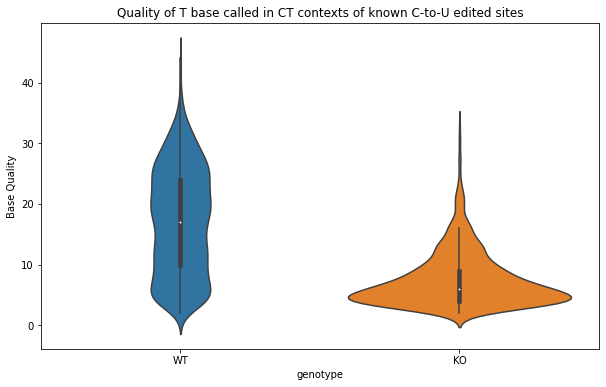

In [14]:
plt.figure(figsize=(10,6))
sn.violinplot(data=df, x="genotype", y="T_qual")
plt.title("Quality of T base called in CT contexts of known C-to-U edited sites")
plt.ylabel("Base Quality")
plt.show()

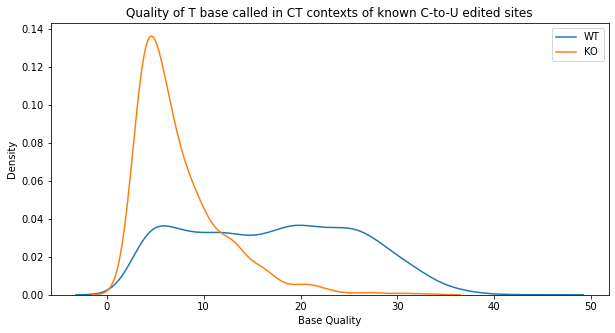

In [15]:
plt.figure(figsize=(10,5))
sn.kdeplot(WT_T_qual, label="WT")
sn.kdeplot(KO_T_qual, label="KO")
plt.xlabel("Base Quality")
plt.title("Quality of T base called in CT contexts of known C-to-U edited sites")
plt.legend()
plt.show()

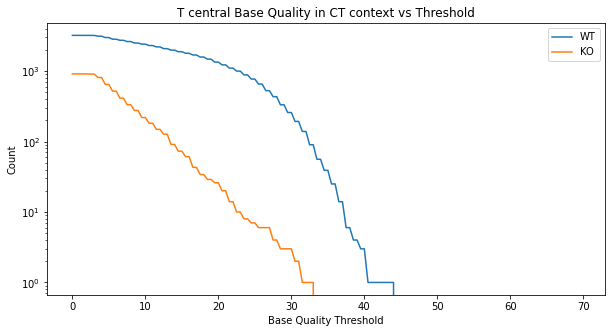

In [16]:
WT_above_threshold = []
KO_above_threshold = []
thresholds = []

for t in np.arange(0, 70, 0.5):
    thresholds.append(t)
    WT_above_threshold.append(df[(df["genotype"] == "WT")&(df["T_qual"] >= t)].shape[0])
    KO_above_threshold.append(df[(df["genotype"] == "KO")&(df["T_qual"] >= t)].shape[0])

plt.figure(figsize=(10,5))
plt.plot(thresholds, WT_above_threshold, label="WT")
plt.plot(thresholds, KO_above_threshold, label="KO")
plt.title("T central Base Quality in CT context vs Threshold")
plt.legend()
plt.xlabel("Base Quality Threshold")
plt.ylabel("Count")
plt.yscale("log")
plt.show()

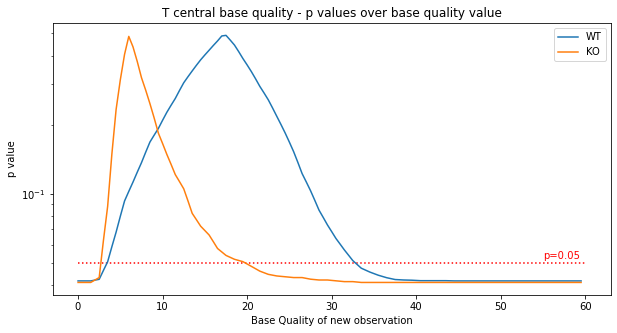

In [17]:
p_WT = []
p_KO = []
quals = []
for qual in np.arange(0,60, 0.5):
    quals.append(qual)
    stat, p = mannwhitneyu(WT_T_qual, [qual])
    p_WT.append(p)
    stat, p = mannwhitneyu(KO_T_qual, [qual])
    p_KO.append(p)

plt.figure(figsize=(10,5))
plt.plot(quals, p_WT, label="WT")
plt.plot(quals, p_KO, label="KO")
plt.title("T central base quality - p values over base quality value")
plt.legend()
plt.xlabel("Base Quality of new observation")
plt.ylabel("p value")
plt.yscale("log")
plt.hlines(0.05, 0, 60, linestyles="dotted", colors="red")
plt.text(55, 0.052, "p=0.05", c="red")
plt.show()

In [18]:
# mismatches chi2 test
from scipy.stats import chi2_contingency

mism_dict = {"KO":[], "WT":[]}

print("KO mismatches count:")
total = np.unique(KO_region_mism, return_counts=True)[1].sum()
print("Total KO reads:", total)
for mism, count in zip(np.unique(KO_region_mism, return_counts=True)[0], np.unique(KO_region_mism, return_counts=True)[1]):
    print(mism,"=", count/total)
    mism_dict["KO"].append(count)
print()

print("WT mismatches count:")
total = np.unique(WT_region_mism, return_counts=True)[1].sum()
print("Total WT reads:", total)
for mism, count in zip(np.unique(WT_region_mism, return_counts=True)[0], np.unique(WT_region_mism, return_counts=True)[1]):
    print(mism,"=", count/total)
    mism_dict["WT"].append(count)

mism_dict = pd.DataFrame(mism_dict).T
print("\n Contingency Table")
print(mism_dict)
print()
chi2_stats, p, dof, ex = chi2_contingency(mism_dict)
print(f"Results of chi2 test:\n\t-chi2 statistics: {chi2_stats}\n\t-p_value: {p}")

KO mismatches count:
Total KO reads: 911
1 = 0.5422612513721186
2 = 0.28869374313940727
3 = 0.13830954994511527
4 = 0.02854006586169045
5 = 0.0021953896816684962

WT mismatches count:
Total WT reads: 3212
1 = 0.7945205479452054
2 = 0.162826899128269
3 = 0.03549190535491906
4 = 0.0062266500622665
5 = 0.0009339975093399751

 Contingency Table
       0    1    2   3  4
KO   494  263  126  26  2
WT  2552  523  114  20  3

Results of chi2 test:
	-chi2 statistics: 281.60136186950336
	-p_value: 1.0062816151726162e-59


In [19]:
# insertion chi2 test

ins_dict = {"KO":[], "WT":[]}

print("KO insertion count:")
total = np.unique(KO_region_ins, return_counts=True)[1].sum()
print("Total KO reads:", total)
for ins_, count in zip(np.unique(KO_region_ins, return_counts=True)[0], np.unique(KO_region_ins, return_counts=True)[1]):
    print(ins_,"=", count/total)
    ins_dict["KO"].append(count)
print()

print("WT insertion count:")
total = np.unique(WT_region_ins, return_counts=True)[1].sum()
print("Total WT reads:", total)
for ins_, count in zip(np.unique(WT_region_ins, return_counts=True)[0], np.unique(WT_region_ins, return_counts=True)[1]):
    print(ins_,"=", count/total)
    ins_dict["WT"].append(count)

ins_dict = pd.DataFrame(ins_dict).T
print("\n Contingency Table")
print(ins_dict)
print()
chi2_stats, p, dof, ex = chi2_contingency(ins_dict)
print(f"Results of chi2 test:\n\t-chi2 statistics: {chi2_stats}\n\t-p_value: {p}")

KO insertion count:
Total KO reads: 911
0.0 = 0.7892425905598244
1.0 = 0.1877058177826564
2.0 = 0.02305159165751921

WT insertion count:
Total WT reads: 3212
0.0 = 0.8707970112079702
1.0 = 0.1232876712328767
2.0 = 0.005915317559153176

 Contingency Table
       0    1   2
KO   719  171  21
WT  2797  396  19

Results of chi2 test:
	-chi2 statistics: 48.432345691571115
	-p_value: 3.041233461828888e-11


In [20]:
# deletions chi2 test

del_dict = {"KO":[], "WT":[]}

print("KO deletetion count:")
total = np.unique(KO_region_dels, return_counts=True)[1].sum()
print("Total KO reads:", total)
for del_, count in zip(np.unique(KO_region_dels, return_counts=True)[0], np.unique(KO_region_dels, return_counts=True)[1]):
    print(del_,"=", count/total)
    del_dict["KO"].append(count)

del_dict["KO"].append(0)    
    
print()

print("WT deletion count:")
total = np.unique(WT_region_dels, return_counts=True)[1].sum()
print("Total WT reads:", total)
for del_, count in zip(np.unique(WT_region_dels, return_counts=True)[0], np.unique(WT_region_dels, return_counts=True)[1]):
    print(del_,"=", count/total)
    del_dict["WT"].append(count)

del_dict = pd.DataFrame(del_dict).T
print("\n Contingency Table")
print(del_dict)
print()
chi2_stats, p, dof, ex = chi2_contingency(del_dict)
print(f"Results of chi2 test:\n\t-chi2 statistics: {chi2_stats}\n\t-p_value: {p}")

KO deletetion count:
Total KO reads: 911
0 = 0.7014270032930845
1 = 0.25905598243688255
2 = 0.038419319429198684
3 = 0.0010976948408342481

WT deletion count:
Total WT reads: 3212
0 = 0.8854296388542964
1 = 0.08872976338729763
2 = 0.024283935242839352
3 = 0.0012453300124533001
4 = 0.00031133250311332503

 Contingency Table
       0    1   2  3  4
KO   639  236  35  1  0
WT  2844  285  78  4  1

Results of chi2 test:
	-chi2 statistics: 196.851097466204
	-p_value: 1.7857690982431883e-41


## General Overview

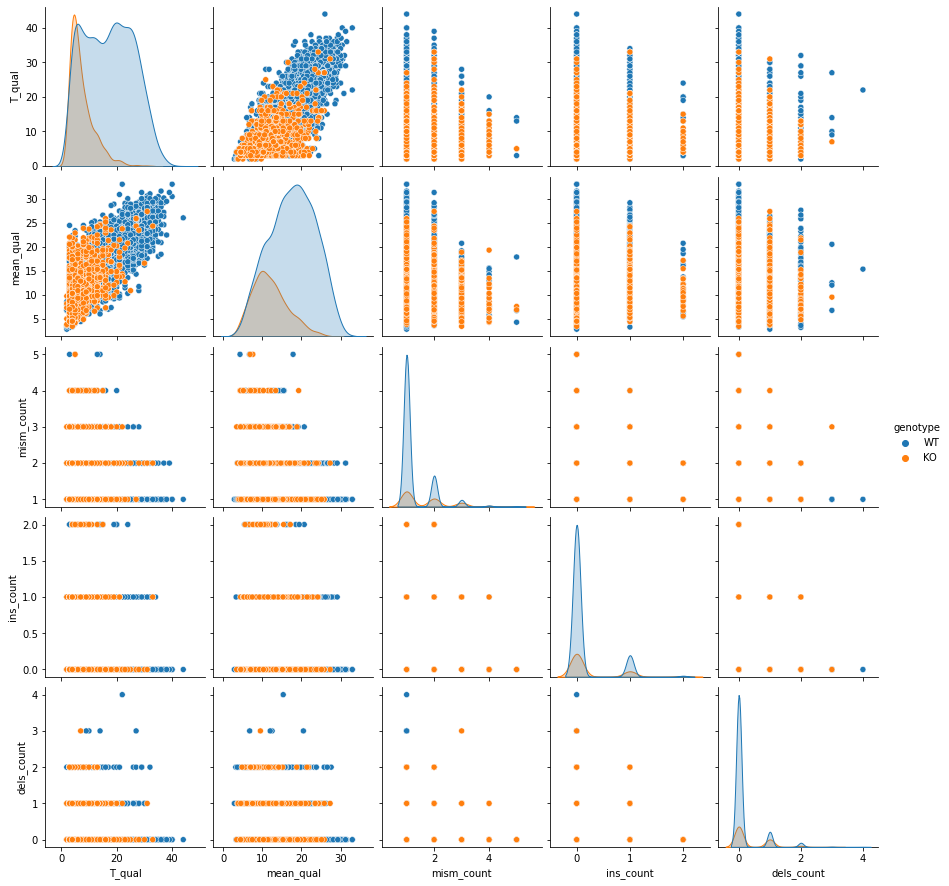

In [21]:
sn.pairplot(pd.DataFrame(df.iloc[:,:-1].values, columns=df.iloc[:, :-1].columns), hue="genotype")
plt.show()

## PCA analysis

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# stardardize dataset
sc = StandardScaler()

df_std = sc.fit_transform(df.iloc[:, :-2])

# perform simple PCA
pca = PCA(n_components=df_std.shape[1])

df_std_pca = pd.DataFrame(pca.fit_transform(df_std), columns=[f"PC{i}" for i in range(1,pca.n_components+1)])
df_std_pca["genotype"] = df.genotype.tolist()
df_std_pca["site"] = df.site.tolist()
df_std_pca

PC1       PC2       PC3       PC4       PC5 genotype  \
0     0.026377  0.113243  0.004642 -0.888407  0.134913       WT   
1    -0.640979  0.103025  0.064619 -0.555117  0.115249       WT   
2     2.711370  3.383585 -1.094526  0.739932 -0.466013       WT   
3     2.317692  3.385553 -1.065527  0.922077 -0.329677       WT   
4     1.389978 -0.957496  1.956606  0.790505  0.125542       WT   
...        ...       ...       ...       ...       ...      ...   
4118  2.542389  3.391659 -1.087849  0.805037 -0.273744       KO   
4119  0.171335  1.780367 -0.477460  0.432854  0.729633       KO   
4120  1.038429 -2.689336 -3.758355  0.978020  0.121596       KO   
4121  1.613810 -0.406451  0.897788 -0.504513  0.190373       KO   
4122 -1.335006  0.136183  0.092041 -0.287721  0.904924       KO   

                site  
0       chr1:4915683  
1       chr1:4915683  
2       chr1:4915683  
3       chr1:4915683  
4       chr1:4915683  
...              ...  
4118  chrX:141022422  
4119  chrX:141022422  
4120  chrX:158170617  
4121  chrX:158170617  
4122  chrX:158170617  

[4123 rows x 7 columns]

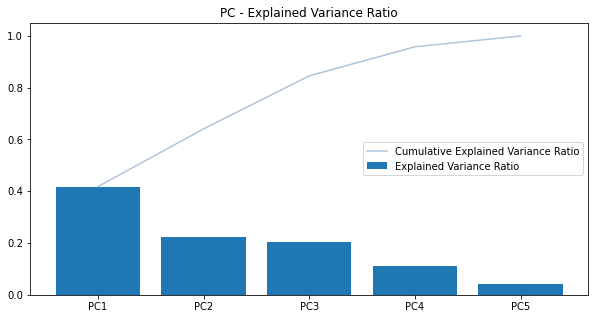

In [23]:
# plot PCs explained variance
plt.figure(figsize=(10,5))
plt.bar([f"PC{i}" for i in range(1, pca.n_components+1)], pca.explained_variance_ratio_, label="Explained Variance Ratio")
plt.plot(np.cumsum(pca.explained_variance_ratio_), label="Cumulative Explained Variance Ratio", c="lightsteelblue")
plt.title("PC - Explained Variance Ratio")
plt.legend(loc="right")
plt.show()

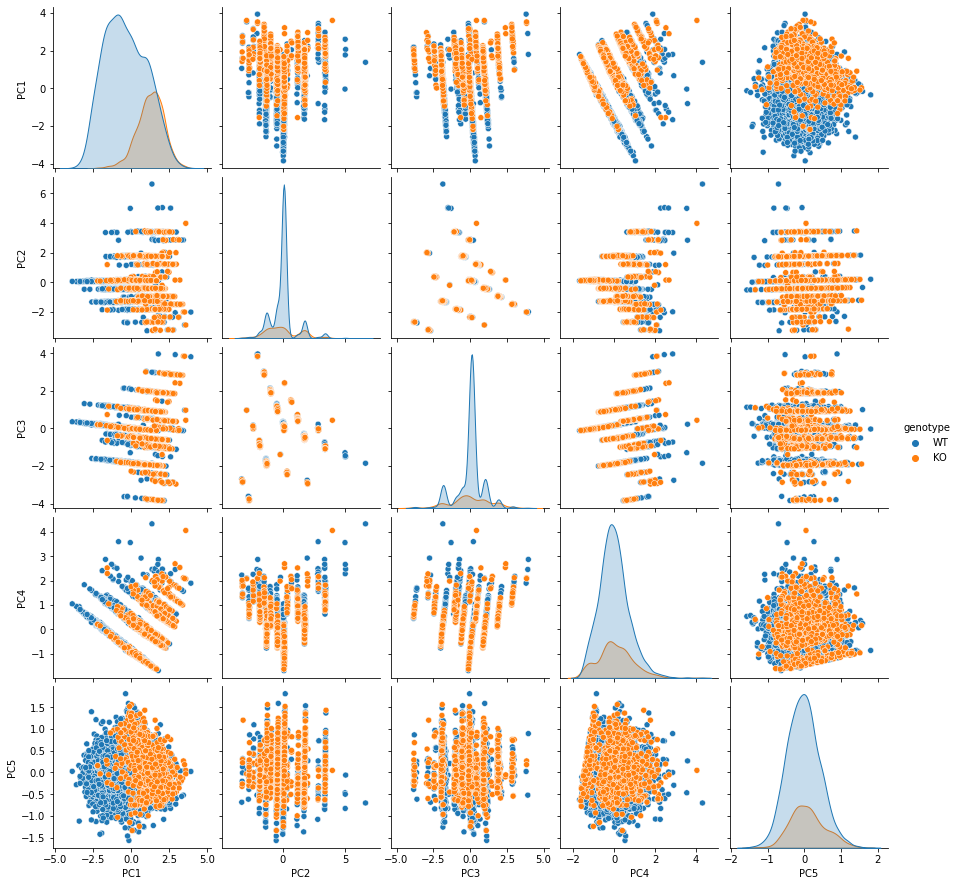

In [24]:
# plot first 3 PCs
sn.pairplot(data=df_std_pca.iloc[:,:-1], hue="genotype")
plt.show()

In [25]:
# get and visualize components and weights to understand features importance.-
PCs = pd.DataFrame(pca.components_, columns=df.iloc[:, :-2].columns, index=df_std_pca.columns[:-2]).T
PCs

PC1       PC2       PC3       PC4       PC5
T_qual     -0.624633 -0.045185  0.084572  0.376398 -0.677469
mean_qual  -0.639280  0.030543  0.025259  0.246303  0.727383
mism_count  0.350628 -0.344151  0.639206  0.582578  0.103143
ins_count   0.136428 -0.544530 -0.729119  0.389817  0.036090
dels_count  0.244135  0.762937 -0.228058  0.553449  0.003043

## t-SNE

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE()

df_std_tsne = pd.DataFrame(tsne.fit_transform(df_std), columns=[f"tSNE{i}" for i in range(1,tsne.n_components+1)])
df_std_tsne["genotype"] = df.genotype.tolist()
df_std_tsne["site"] = df.site.tolist()
df_std_tsne

tSNE1      tSNE2 genotype            site
0    -59.166489   0.866620       WT    chr1:4915683
1    -49.357780 -18.191774       WT    chr1:4915683
2      0.185833   5.723130       WT    chr1:4915683
3      1.765589   4.985006       WT    chr1:4915683
4     58.840580 -43.425003       WT    chr1:4915683
...         ...        ...      ...             ...
4118   1.043599   5.842784       KO  chrX:141022422
4119  63.973866  -2.762312       KO  chrX:141022422
4120  34.782768  32.152710       KO  chrX:158170617
4121  27.192297  65.560570       KO  chrX:158170617
4122 -14.720328 -16.421925       KO  chrX:158170617

[4123 rows x 4 columns]

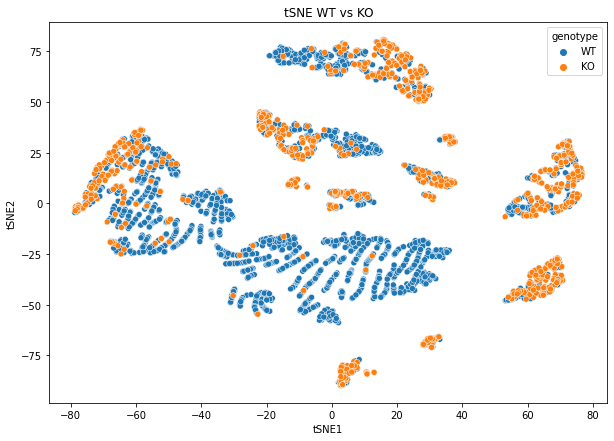

In [27]:
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_std_tsne.iloc[:,:-1], x="tSNE1", y="tSNE2", hue="genotype")
plt.title("tSNE WT vs KO")
plt.show()

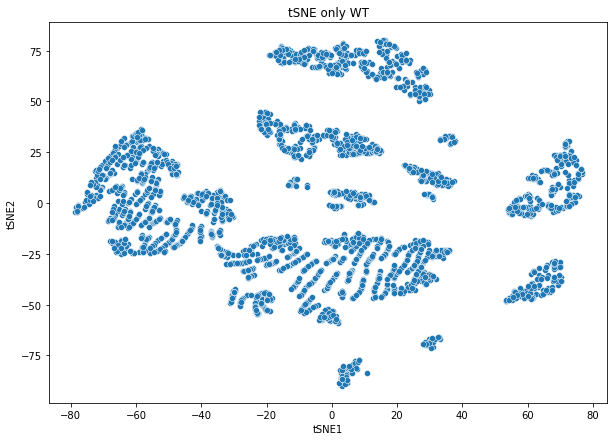

In [28]:
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_std_tsne[df_std_tsne["genotype"]=="WT"].iloc[:,:-1], x="tSNE1", y="tSNE2")
plt.title("tSNE only WT")
plt.show()

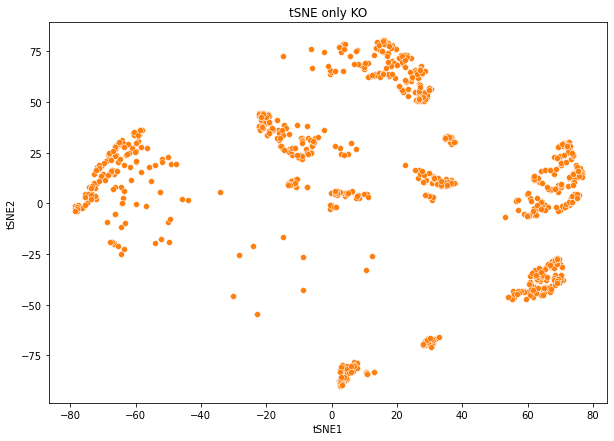

In [29]:
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_std_tsne[df_std_tsne["genotype"]=="KO"].iloc[:,:-1], x="tSNE1", y="tSNE2", color=sn.color_palette()[1])
plt.title("tSNE only KO")
plt.show()

### 5-mers analysis on reference context analysis
The goal of this section is to understands if sites with a similar k-mer fall within the same cluster seen in the t-SNE analysis.

In [30]:
df_std_tsne["ref_context"] = WT_ref_contexts + KO_ref_contexts
df_std_tsne

tSNE1      tSNE2 genotype            site ref_context
0    -59.166489   0.866620       WT    chr1:4915683       CACAT
1    -49.357780 -18.191774       WT    chr1:4915683       CACAT
2      0.185833   5.723130       WT    chr1:4915683       CACAT
3      1.765589   4.985006       WT    chr1:4915683       CACAT
4     58.840580 -43.425003       WT    chr1:4915683       CACAT
...         ...        ...      ...             ...         ...
4118   1.043599   5.842784       KO  chrX:141022422       AACTA
4119  63.973866  -2.762312       KO  chrX:141022422       AACTA
4120  34.782768  32.152710       KO  chrX:158170617       TTCTA
4121  27.192297  65.560570       KO  chrX:158170617       TTCTA
4122 -14.720328 -16.421925       KO  chrX:158170617       TTCTA

[4123 rows x 5 columns]

In [31]:
df_std_tsne["ref_context"].value_counts()

TACAC    310
TACTT    304
GACTT    289
CACAT    247
TACTG    207
        ... 
TTCCC      2
TTCGC      1
CTCAT      1
AACTC      1
AGCGC      1
Name: ref_context, Length: 74, dtype: int64

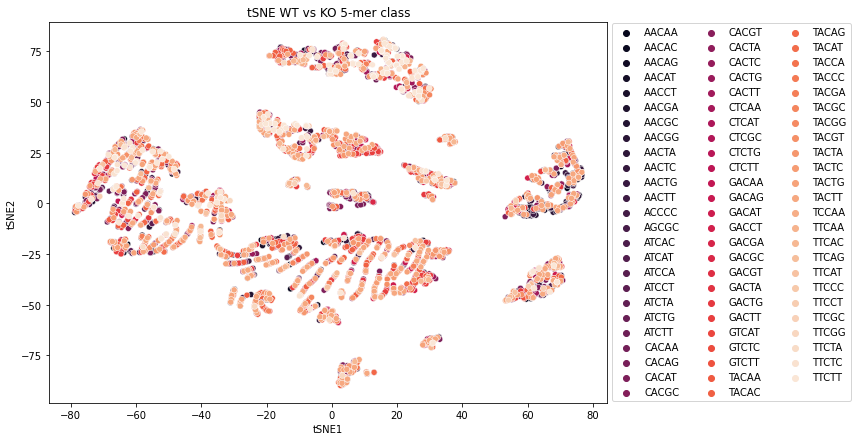

In [32]:
# visualize tSNE with ref_context (5-mer) class WT and KO
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_std_tsne[["tSNE1", "tSNE2", "ref_context"]].sort_values("ref_context"), 
               x="tSNE1", 
               y="tSNE2", 
               hue="ref_context", 
               palette="rocket")
plt.title("tSNE WT vs KO 5-mer class")
plt.legend(bbox_to_anchor=(1, 1.01), ncol=3)
plt.show()

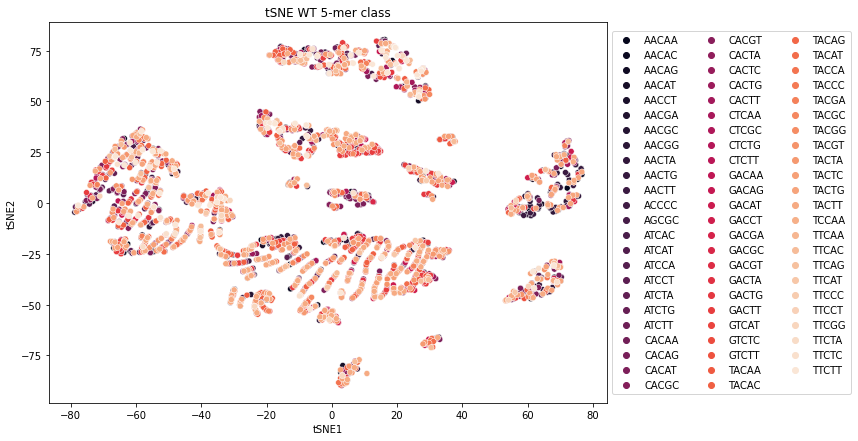

In [33]:
# visualize tSNE with ref_context (5-mer) class WT
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_std_tsne.query("genotype == 'WT'")[["tSNE1", "tSNE2", "ref_context"]].sort_values("ref_context"), 
               x="tSNE1", 
               y="tSNE2", 
               hue="ref_context", 
               palette="rocket")
plt.title("tSNE WT 5-mer class")
plt.legend(bbox_to_anchor=(1, 0.99), ncol=3)
plt.show()

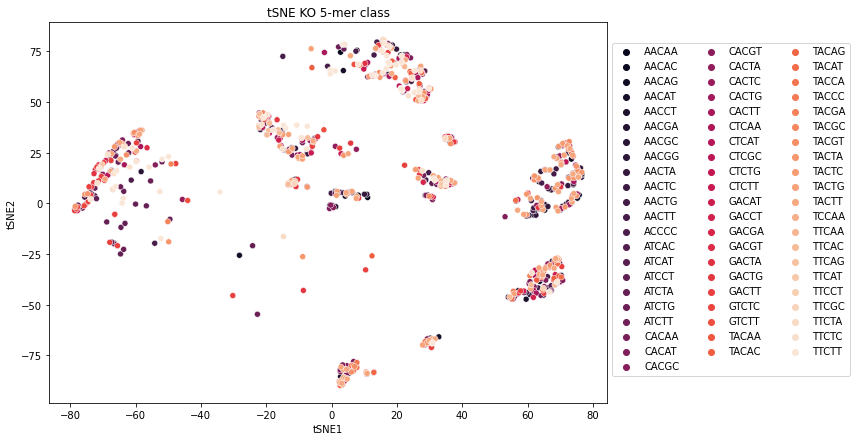

In [34]:
# visualize tSNE with ref_context (5-mer) class KO
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_std_tsne.query("genotype == 'KO'")[["tSNE1", "tSNE2", "ref_context"]].sort_values("ref_context"), 
               x="tSNE1", 
               y="tSNE2", 
               hue="ref_context", 
               palette="rocket")
plt.title("tSNE KO 5-mer class")
plt.legend(bbox_to_anchor=(1, 0.96), ncol=3)
plt.show()

In [35]:
# plot interactive scatterplot with pyplot express
import plotly.express as px
fig = px.scatter(df_std_tsne.sort_values("ref_context"), 
                 x="tSNE1", 
                 y="tSNE2", 
                 color="ref_context")

# put title inside figure
fig.update_layout(
    title={
        'text': "tSNE WT vs KO 5-mer class",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

The composition of each cluster showed into t-SNE in terms of 5-mer is quite eterogeneous. This lead to think that there isn't a clear pattern that is brought by a specific 5-mer.

### SVM One Class model: first approach without fine tuning on whole KO dataset
Now, I'm going to build a Support Vector Machine One Class on the entire KO dataset in order to obtain a first, expeditious understanding of the feasibility of this model to take trace of novelty detection on KO sites. The sites classified as novelty should be the real T within a CT context. This could be used to decrease the I type error when calling a C-to-U editing site since Nanopore ONT direct-RNA sequencing seem to call T also in KO.

In [36]:
# importing SVM OC module and class
from sklearn.svm import OneClassSVM

sc = StandardScaler()

X = sc.fit_transform(df.iloc[:,:-2].values)
X_train = X[df[df["genotype"] == "WT"].shape[0]:] # training on KO sites
X_test = X[:df[df["genotype"] == "WT"].shape[0]] # testing on WT sites (some of those should be classified as novelty)

In [37]:
# training the model
svm_oc = OneClassSVM(kernel="rbf")

svm_oc.fit(X_train)
y_hat_KO = svm_oc.predict(X_train)
y_hat_KO

/lustrehome/afonzino/.conda/envs/nanocompore/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



array([ 1, -1,  1,  1, -1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1, -1,
        1, -1,  1, -1, -1, -1,  1,  1, -1, -1,  1,  1, -1,  1, -1,  1,  1,
        1,  1,  1, -1,  1,  1,  1, -1, -1,  1, -1, -1,  1,  1, -1, -1, -1,
       -1, -1,  1, -1,  1, -1,  1, -1, -1,  1, -1,  1,  1, -1,  1,  1, -1,
        1, -1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  1, -1,
       -1, -1, -1, -1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,
       -1,  1, -1,  1,  1,  1,  1, -1, -1,  1,  1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1, -1,  1, -1,  1,
        1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1,  1, -1, -1, -1,  1,
        1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1, -1, -1,
       -1,  1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1, -1,  1, -1,  1, -1,
        1,  1,  1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1, -1,
        1,  1, -1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1, -1,  1,  1, -1,
        1,  1,  1,  1, -1

In [38]:
# quickly predict on WT
y_hat_WT = svm_oc.predict(X_test)
y_hat_WT

array([ 1, -1, -1, ...,  1, -1, -1])

In [39]:
# print predicted results for KO sites
np.unique(y_hat_KO, return_counts=True)

(array([-1,  1]), array([454, 457]))

In [40]:
# print predicted results for WT sites 
np.unique(y_hat_WT, return_counts=True)

(array([-1,  1]), array([2374,  838]))

In [41]:
df_std_tsne

tSNE1      tSNE2 genotype            site ref_context
0    -59.166489   0.866620       WT    chr1:4915683       CACAT
1    -49.357780 -18.191774       WT    chr1:4915683       CACAT
2      0.185833   5.723130       WT    chr1:4915683       CACAT
3      1.765589   4.985006       WT    chr1:4915683       CACAT
4     58.840580 -43.425003       WT    chr1:4915683       CACAT
...         ...        ...      ...             ...         ...
4118   1.043599   5.842784       KO  chrX:141022422       AACTA
4119  63.973866  -2.762312       KO  chrX:141022422       AACTA
4120  34.782768  32.152710       KO  chrX:158170617       TTCTA
4121  27.192297  65.560570       KO  chrX:158170617       TTCTA
4122 -14.720328 -16.421925       KO  chrX:158170617       TTCTA

[4123 rows x 5 columns]

In [42]:
y_hat = y_hat_WT.tolist() + y_hat_KO.tolist()
y_hat

[1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,

In [43]:
# decode label predicted as -1 --> T real, +1 --> T false (to be escluded)
labels = {-1:"T real", 1:"T false"}
labels

{-1: 'T real', 1: 'T false'}

In [44]:
y_hat_decoded = []
for prediction in y_hat:
    y_hat_decoded.append(labels[prediction])
y_hat_decoded

['T false',
 'T real',
 'T real',
 'T real',
 'T real',
 'T false',
 'T false',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T false',
 'T real',
 'T real',
 'T false',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T false',
 'T real',
 'T false',
 'T false',
 'T false',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T false',
 'T false',
 'T false',
 'T false',
 'T real',
 'T real',
 'T false',
 'T real',
 'T real',
 'T false',
 'T real',
 'T real',
 'T real',
 'T false',
 'T real',
 'T false',
 'T false',
 'T real',
 'T false',
 'T real',
 'T real',
 'T false',
 'T false',
 'T real',
 'T real',
 'T real',
 'T real',
 'T false',
 'T real',
 'T false',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T false',
 'T false',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T real',
 'T false',
 'T real',
 'T real',
 'T real',
 'T real',
 'T false',
 'T real',
 'T real',
 'T f

In [45]:
# appending predicted labels to df_std_tsne to visulize afterwards
df_std_tsne["y_hat"] = y_hat_decoded
df_std_tsne

tSNE1      tSNE2 genotype            site ref_context    y_hat
0    -59.166489   0.866620       WT    chr1:4915683       CACAT  T false
1    -49.357780 -18.191774       WT    chr1:4915683       CACAT   T real
2      0.185833   5.723130       WT    chr1:4915683       CACAT   T real
3      1.765589   4.985006       WT    chr1:4915683       CACAT   T real
4     58.840580 -43.425003       WT    chr1:4915683       CACAT   T real
...         ...        ...      ...             ...         ...      ...
4118   1.043599   5.842784       KO  chrX:141022422       AACTA   T real
4119  63.973866  -2.762312       KO  chrX:141022422       AACTA   T real
4120  34.782768  32.152710       KO  chrX:158170617       TTCTA   T real
4121  27.192297  65.560570       KO  chrX:158170617       TTCTA  T false
4122 -14.720328 -16.421925       KO  chrX:158170617       TTCTA   T real

[4123 rows x 6 columns]

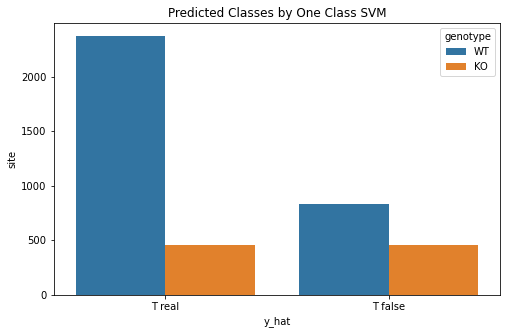

In [46]:
plt.figure(figsize=(8,5))
sn.barplot(data=df_std_tsne.groupby(["genotype", "y_hat"]).count().sort_index(ascending=False).reset_index(), 
           x="y_hat", 
           y="site", 
           hue="genotype")
plt.title("Predicted Classes by One Class SVM")
plt.show()

In [47]:
df_std_tsne.groupby(["genotype", "y_hat"]).count().sort_index(ascending=False)

tSNE1  tSNE2  site  ref_context
genotype y_hat                                   
WT       T real    2374   2374  2374         2374
         T false    838    838   838          838
KO       T real     454    454   454          454
         T false    457    457   457          457

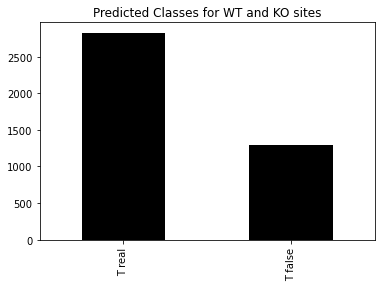

In [48]:
df_std_tsne.y_hat.value_counts().plot(kind="bar", color="Black")
plt.title("Predicted Classes for WT and KO sites")
plt.show()

In [49]:
df_std_tsne.y_hat.value_counts()

T real     2828
T false    1295
Name: y_hat, dtype: int64

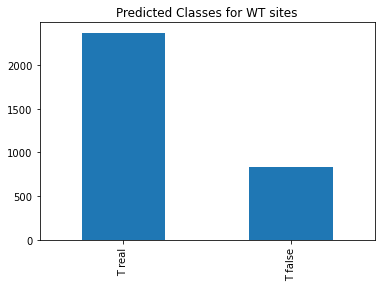

In [50]:
df_std_tsne[df_std_tsne["genotype"]=="WT"].y_hat.value_counts().plot(kind="bar")
plt.title("Predicted Classes for WT sites")
plt.show()

In [51]:
df_std_tsne[df_std_tsne["genotype"]=="WT"].y_hat.value_counts()

T real     2374
T false     838
Name: y_hat, dtype: int64

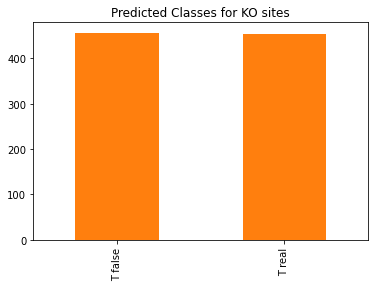

In [52]:
df_std_tsne[df_std_tsne["genotype"]=="KO"].y_hat.value_counts().plot(kind="bar", color=sn.color_palette()[1])
plt.title("Predicted Classes for KO sites")
plt.show()

In [53]:
df_std_tsne[df_std_tsne["genotype"]=="KO"].y_hat.value_counts()

T false    457
T real     454
Name: y_hat, dtype: int64

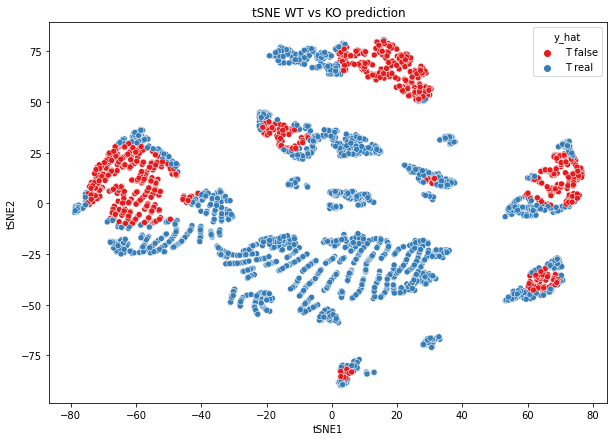

In [54]:
# visualize tSNE with predicted labels 
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_std_tsne[["tSNE1", "tSNE2", "y_hat"]], x="tSNE1", y="tSNE2", hue="y_hat", palette="Set1")
plt.title("tSNE WT vs KO prediction")
plt.show()

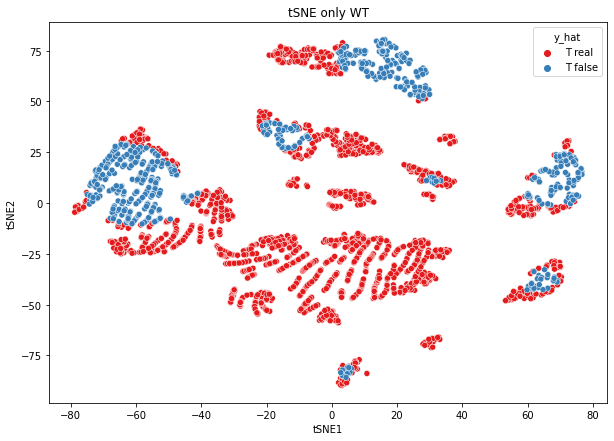

In [55]:
# visualize tSNE with predicted labels
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_std_tsne[df_std_tsne["genotype"]=="WT"][["tSNE1", "tSNE2", "y_hat"]].sort_values("y_hat", 
                                                                                                        ascending=False), 
               x="tSNE1", 
               y="tSNE2", 
               hue="y_hat", 
               palette="Set1")
plt.title("tSNE only WT")
plt.show()

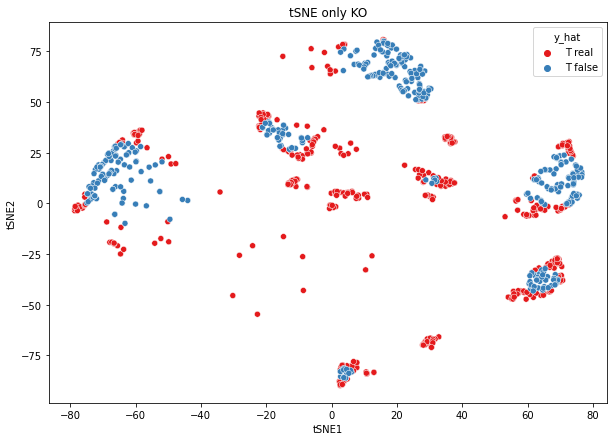

In [56]:
# visualize tSNE with predicted labels
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_std_tsne[df_std_tsne["genotype"]=="KO"][["tSNE1", "tSNE2", "y_hat"]].sort_values("y_hat", 
                                                                                                        ascending=False), 
               x="tSNE1", 
               y="tSNE2", 
               hue="y_hat",
               palette="Set1")
plt.title("tSNE only KO")
plt.show()

Very well! The classifier One Class SVM is able to perform nicely on these data. Let's start with fine tuning of hyperparameters.

## Fine tune the OC-SVM model
Fine tuning of the SVM One-Class classifier via Cross Validation and Grid Search. All the KO samples will be labelled as +1 (regula observation). In the end we are trying to model the baseline error on the CT context using known T less sites retrieved from known edited position from KO run.

In [57]:
# import train-test split module
from sklearn.model_selection import train_test_split

# import gridsearch CV from sklearn library
from sklearn.model_selection import GridSearchCV

# create X_train_KO, X_test_KO, and X_WT datasets and standardize data all together
sc = StandardScaler()

X = sc.fit_transform(df.iloc[:,:-2].values)

X_KO = X[df[df["genotype"] == "WT"].shape[0]:] # KO sites
X_KO_train, X_KO_test = train_test_split(X[df[df["genotype"] == "WT"].shape[0]:], test_size=0.3) # train-test split
X_WT = X[:df[df["genotype"] == "WT"].shape[0]] # WT sites

y_KO_train = np.array([1 for i in range(X_KO_train.shape[0])])
y_KO_test = np.array([1 for i in range(X_KO_test.shape[0])])

print("# Dataset sizes:")
print("\tX_KO_train size:", X_KO_train.shape)
print("\tX_KO_test size:", X_KO_test.shape)
print("\tX_WT size:", X_WT.shape)
print("\ty_KO_train size:", y_KO_train.shape)
print("\ty_KO_test size:", y_KO_test.shape)
print()

# Dataset sizes:
	X_KO_train size: (637, 5)
	X_KO_test size: (274, 5)
	X_WT size: (3212, 5)
	y_KO_train size: (637,)
	y_KO_test size: (274,)



In [58]:
# start grid search to find best hyperparameters
parameters = {"nu":[0.01, 0.09, 0.1, 0.9],
              "gamma":[0.1, 1, 3, 10, 30, 100, 300, 1000, 3000]}

svc = OneClassSVM()

clf = GridSearchCV(svc, parameters, cv=10, verbose=3, scoring="accuracy", return_train_score=True)
clf.fit(X_KO_train, y_KO_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] gamma=0.1, nu=0.01 ..............................................
[CV]  gamma=0.1, nu=0.01, score=(train=0.984, test=0.969), total=   0.0s
[CV] gamma=0.1, nu=0.01 ..............................................
[CV]  gamma=0.1, nu=0.01, score=(train=0.984, test=0.938), total=   0.0s
[CV] gamma=0.1, nu=0.01 ..............................................
[CV]  gamma=0.1, nu=0.01, score=(train=0.984, test=0.984), total=   0.0s
[CV] gamma=0.1, nu=0.01 ..............................................
[CV]  gamma=0.1, nu=0.01, score=(train=0.986, test=0.969), total=   0.0s
[CV] gamma=0.1, nu=0.01 ..............................................
[CV]  gamma=0.1, nu=0.01, score=(train=0.981, test=0.969), total=   0.0s
[CV] gamma=0.1, nu=0.01 ..............................................
[CV]  gamma=0.1, nu=0.01, score=(train=0.981, test=0.953), total=   0.0s
[CV] gamma=0.1, nu=0.01 ..............................................
[C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  gamma=0.1, nu=0.9, score=(train=0.103, test=0.079), total=   0.0s
[CV] gamma=0.1, nu=0.9 ...............................................
[CV]  gamma=0.1, nu=0.9, score=(train=0.099, test=0.127), total=   0.0s
[CV] gamma=0.1, nu=0.9 ...............................................
[CV]  gamma=0.1, nu=0.9, score=(train=0.101, test=0.111), total=   0.0s
[CV] gamma=1, nu=0.01 ................................................
[CV]  gamma=1, nu=0.01, score=(train=0.923, test=0.812), total=   0.0s
[CV] gamma=1, nu=0.01 ................................................
[CV]  gamma=1, nu=0.01, score=(train=0.911, test=0.797), total=   0.0s
[CV] gamma=1, nu=0.01 ................................................
[CV]  gamma=1, nu=0.01, score=(train=0.914, test=0.797), total=   0.0s
[CV] gamma=1, nu=0.01 ................................................
[CV]  gamma=1, nu=0.01, score=(train=0.895, test=0.797), total=   0.0s
[CV] gamma=1, nu=0.01 ................................................
[CV

[CV] . gamma=3, nu=0.9, score=(train=0.087, test=0.094), total=   0.0s
[CV] gamma=3, nu=0.9 .................................................
[CV] . gamma=3, nu=0.9, score=(train=0.096, test=0.062), total=   0.0s
[CV] gamma=3, nu=0.9 .................................................
[CV] . gamma=3, nu=0.9, score=(train=0.101, test=0.109), total=   0.0s
[CV] gamma=3, nu=0.9 .................................................
[CV] . gamma=3, nu=0.9, score=(train=0.101, test=0.111), total=   0.0s
[CV] gamma=3, nu=0.9 .................................................
[CV] . gamma=3, nu=0.9, score=(train=0.098, test=0.079), total=   0.0s
[CV] gamma=3, nu=0.9 .................................................
[CV] . gamma=3, nu=0.9, score=(train=0.094, test=0.159), total=   0.0s
[CV] gamma=10, nu=0.01 ...............................................
[CV]  gamma=10, nu=0.01, score=(train=0.696, test=0.406), total=   0.0s
[CV] gamma=10, nu=0.01 ...............................................
[CV] 

[CV]  gamma=30, nu=0.09, score=(train=0.660, test=0.156), total=   0.0s
[CV] gamma=30, nu=0.09 ...............................................
[CV]  gamma=30, nu=0.09, score=(train=0.597, test=0.250), total=   0.0s
[CV] gamma=30, nu=0.09 ...............................................
[CV]  gamma=30, nu=0.09, score=(train=0.639, test=0.297), total=   0.0s
[CV] gamma=30, nu=0.09 ...............................................
[CV]  gamma=30, nu=0.09, score=(train=0.550, test=0.359), total=   0.0s
[CV] gamma=30, nu=0.09 ...............................................
[CV]  gamma=30, nu=0.09, score=(train=0.564, test=0.238), total=   0.0s
[CV] gamma=30, nu=0.09 ...............................................
[CV]  gamma=30, nu=0.09, score=(train=0.648, test=0.143), total=   0.0s
[CV] gamma=30, nu=0.09 ...............................................
[CV]  gamma=30, nu=0.09, score=(train=0.598, test=0.302), total=   0.0s
[CV] gamma=30, nu=0.1 ................................................

[CV]  gamma=100, nu=0.9, score=(train=0.122, test=0.047), total=   0.0s
[CV] gamma=100, nu=0.9 ...............................................
[CV]  gamma=100, nu=0.9, score=(train=0.120, test=0.047), total=   0.0s
[CV] gamma=100, nu=0.9 ...............................................
[CV]  gamma=100, nu=0.9, score=(train=0.133, test=0.016), total=   0.0s
[CV] gamma=100, nu=0.9 ...............................................
[CV]  gamma=100, nu=0.9, score=(train=0.120, test=0.000), total=   0.0s
[CV] gamma=100, nu=0.9 ...............................................
[CV]  gamma=100, nu=0.9, score=(train=0.124, test=0.047), total=   0.0s
[CV] gamma=100, nu=0.9 ...............................................
[CV]  gamma=100, nu=0.9, score=(train=0.115, test=0.062), total=   0.0s
[CV] gamma=100, nu=0.9 ...............................................
[CV]  gamma=100, nu=0.9, score=(train=0.139, test=0.048), total=   0.0s
[CV] gamma=100, nu=0.9 ...............................................

[CV]  gamma=1000, nu=0.09, score=(train=0.660, test=0.062), total=   0.0s
[CV] gamma=1000, nu=0.09 .............................................
[CV]  gamma=1000, nu=0.09, score=(train=0.360, test=0.016), total=   0.0s
[CV] gamma=1000, nu=0.09 .............................................
[CV]  gamma=1000, nu=0.09, score=(train=0.428, test=0.047), total=   0.0s
[CV] gamma=1000, nu=0.09 .............................................
[CV]  gamma=1000, nu=0.09, score=(train=0.674, test=0.047), total=   0.0s
[CV] gamma=1000, nu=0.09 .............................................
[CV]  gamma=1000, nu=0.09, score=(train=0.368, test=0.000), total=   0.0s
[CV] gamma=1000, nu=0.09 .............................................
[CV]  gamma=1000, nu=0.09, score=(train=0.714, test=0.111), total=   0.0s
[CV] gamma=1000, nu=0.09 .............................................
[CV]  gamma=1000, nu=0.09, score=(train=0.521, test=0.016), total=   0.0s
[CV] gamma=1000, nu=0.09 ...............................

[CV]  gamma=3000, nu=0.9, score=(train=0.524, test=0.031), total=   0.0s
[CV] gamma=3000, nu=0.9 ..............................................
[CV]  gamma=3000, nu=0.9, score=(train=0.449, test=0.047), total=   0.0s
[CV] gamma=3000, nu=0.9 ..............................................
[CV]  gamma=3000, nu=0.9, score=(train=0.692, test=0.063), total=   0.0s
[CV] gamma=3000, nu=0.9 ..............................................
[CV]  gamma=3000, nu=0.9, score=(train=0.300, test=0.032), total=   0.0s
[CV] gamma=3000, nu=0.9 ..............................................
[CV]  gamma=3000, nu=0.9, score=(train=0.303, test=0.000), total=   0.0s


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    6.0s finished
/lustrehome/afonzino/.conda/envs/nanocompore/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=OneClassSVM(cache_size=200, coef0=0.0, degree=3,
                                   gamma='auto_deprecated', kernel='rbf',
                                   max_iter=-1, nu=0.5, random_state=None,
                                   shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'gamma': [0.1, 1, 3, 10, 30, 100, 300, 1000, 3000],
                         'nu': [0.01, 0.09, 0.1, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=3)

In [59]:
# best parameters
clf.best_params_

{'gamma': 0.1, 'nu': 0.01}

In [60]:
# print best estimator
clf.best_estimator_

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
            max_iter=-1, nu=0.01, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [61]:
# validation accuracy with best parameters
clf.best_score_

0.9686028257456829

In [62]:
# plot validation matrices
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_gamma', 'param_nu', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])

In [63]:
# Extracting CV results.
#For each fold (5 folds) extract scores of train and test sets as mean, and standard deviation
# of the 88 combinations of hyper-parameters.
cvOutput_param = pd.DataFrame(clf.cv_results_["params"])
cvOutput_param["TrainMean"] = clf.cv_results_["mean_train_score"]
cvOutput_param["TrainStd"] = clf.cv_results_["std_train_score"]
cvOutput_param["TestMean"] = clf.cv_results_["mean_test_score"]
cvOutput_param["TestStd"] = clf.cv_results_["std_test_score"]
cvOutput_param

gamma    nu  TrainMean  TrainStd  TestMean   TestStd
0      0.1  0.01   0.983255  0.001776  0.968603  0.013927
1      0.1  0.09   0.909995  0.001562  0.894819  0.040154
2      0.1  0.10   0.899355  0.002350  0.891680  0.040421
3      0.1  0.90   0.100820  0.001871  0.098901  0.034463
4      1.0  0.01   0.907205  0.009176  0.816327  0.044871
5      1.0  0.09   0.903190  0.005936  0.821036  0.041972
6      1.0  0.10   0.903541  0.003388  0.824176  0.044590
7      1.0  0.90   0.099948  0.001406  0.092622  0.031195
8      3.0  0.01   0.810745  0.008085  0.675039  0.056421
9      3.0  0.09   0.835691  0.008539  0.676609  0.054907
10     3.0  0.10   0.837434  0.007448  0.678179  0.049823
11     3.0  0.90   0.096109  0.003917  0.091052  0.037319
12    10.0  0.01   0.683413  0.013058  0.455259  0.072727
13    10.0  0.09   0.715516  0.015025  0.470958  0.074271
14    10.0  0.10   0.722668  0.019948  0.475667  0.074938
15    10.0  0.90   0.098900  0.006071  0.083203  0.029873
16    30.0  0.01   0.583459  0.028383  0.249608  0.064800
17    30.0  0.09   0.607014  0.033327  0.240188  0.063746
18    30.0  0.10   0.614513  0.021545  0.254317  0.065604
19    30.0  0.90   0.106573  0.006545  0.058085  0.032264
20   100.0  0.01   0.492243  0.047871  0.111460  0.040870
21   100.0  0.09   0.565847  0.030607  0.117739  0.023518
22   100.0  0.10   0.566907  0.049777  0.111460  0.026730
23   100.0  0.90   0.123671  0.010302  0.036107  0.021092
24   300.0  0.01   0.601791  0.022626  0.075353  0.025380
25   300.0  0.09   0.610178  0.071687  0.070644  0.040513
26   300.0  0.10   0.476906  0.049423  0.064364  0.032530
27   300.0  0.90   0.153845  0.014242  0.025118  0.017478
28  1000.0  0.01   0.376955  0.025243  0.043956  0.031184
29  1000.0  0.09   0.537889  0.125577  0.045526  0.031104
30  1000.0  0.10   0.447590  0.036596  0.029827  0.028458
31  1000.0  0.90   0.161860  0.031299  0.023548  0.021333
32  3000.0  0.01   0.741487  0.077869  0.054945  0.024623
33  3000.0  0.09   0.599683  0.038321  0.061224  0.020407
34  3000.0  0.10   0.485262  0.053981  0.037677  0.020211
35  3000.0  0.90   0.502566  0.122698  0.039246  0.022437

In [64]:
# print CV results for the 
cvOutput_param[(cvOutput_param["gamma"]==clf.best_params_["gamma"]) & (cvOutput_param["nu"]==clf.best_params_["nu"])]

gamma    nu  TrainMean  TrainStd  TestMean   TestStd
0    0.1  0.01   0.983255  0.001776  0.968603  0.013927

## SVM One Class model: evaluate on test set using best parameters
Assessing quickly the ability of the OC-SVM to generalize on unknown KO's and WT test data.

In [65]:
# retrieve best estimator
oc_svm = clf.best_estimator_

# retrain it on the entire X_KO_train dataset
oc_svm.fit(X_KO_train)
print("OC-SVM paramters:", oc_svm.get_params())
print()

# predict classes for KO train and test datasets
y_hat_KO_train = oc_svm.predict(X_KO_train)
y_hat_KO_test = oc_svm.predict(X_KO_test)

# quickly predict on WT dataset
y_hat_WT = oc_svm.predict(X_WT)

# print predicted results for KO sites
print("# KO train")
KO_train_abnormal = y_hat_KO_train.tolist().count(-1)
KO_train_regular = y_hat_KO_train.tolist().count(1)
print(f"\t-1 (abnomal) count: {KO_train_abnormal}")
print(f"\t+1 (regular) count: {KO_train_regular}")
print("\t-1 (abnormal) class:", round( 100 * (KO_train_abnormal / (KO_train_abnormal + KO_train_regular)), 2), "%")
print("\t+1 (regular) class:", round( 100 * (KO_train_regular / (KO_train_abnormal + KO_train_regular)), 2), "%")
if KO_train_regular != 0:    
    KO_train_ratio = round(KO_train_abnormal / KO_train_regular, 2)
    print("\tRatio -1/+1 classes:", KO_train_ratio)
else:
    KO_train_ratio = "inf."
    print("\tRatio -1/+1 classes:", KO_train_ratio)
    
print()
print("# KO test")
KO_test_abnormal = y_hat_KO_test.tolist().count(-1)
KO_test_regular = y_hat_KO_test.tolist().count(1)
print(f"\t-1 (abnomal) count: {KO_test_abnormal}")
print(f"\t+1 (regular) count: {KO_test_regular}")
print("\t-1 (abnormal) class:", round( 100 * (KO_test_abnormal / (KO_test_abnormal + KO_test_regular)), 2), "%")
print("\t+1 (regular) class:", round( 100 * (KO_test_regular / (KO_test_abnormal + KO_test_regular)), 2), "%")
if KO_test_regular != 0:    
    KO_test_ratio = round(KO_test_abnormal / KO_test_regular, 2)
    print("\tRatio -1/+1 classes:", KO_test_ratio)
else:
    KO_test_ratio = "inf."
    print("\tRatio -1/+1 classes:", KO_test_ratio)

# print predicted results for WT sites 
print()
print("# WT")
WT_abnormal = y_hat_WT.tolist().count(-1)
WT_regular = y_hat_WT.tolist().count(1)
print(f"\t-1 (abnomal) count: {WT_abnormal}")
print(f"\t+1 (regular) count: {WT_regular}")
print("\t-1 (abnormal) class:", round( 100 * (WT_abnormal / (WT_abnormal + WT_regular)), 2), "%")
print("\t+1 (regular) class:", round( 100 * (WT_regular / (WT_abnormal + WT_regular)), 2), "%")
if WT_regular != 0:
    WT_ratio = round(WT_abnormal / WT_regular, 2)
    print("\tRatio -1/+1 classes:", WT_ratio)
else:
    KO_test_ratio = "inf."
    print("\tRatio -1/+1 classes:", WT_ratio)
 
if WT_ratio != "inf." and KO_test_ratio != "inf.":
    if KO_test_ratio != 0:
        print("\nRATIO WT / KO:", WT_ratio/KO_test_ratio)
    else:
        print("\nRATIO WT / KO: inf.")

OC-SVM paramters: {'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'nu': 0.01, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

# KO train
	-1 (abnomal) count: 10
	+1 (regular) count: 627
	-1 (abnormal) class: 1.57 %
	+1 (regular) class: 98.43 %
	Ratio -1/+1 classes: 0.02

# KO test
	-1 (abnomal) count: 13
	+1 (regular) count: 261
	-1 (abnormal) class: 4.74 %
	+1 (regular) class: 95.26 %
	Ratio -1/+1 classes: 0.05

# WT
	-1 (abnomal) count: 428
	+1 (regular) count: 2784
	-1 (abnormal) class: 13.33 %
	+1 (regular) class: 86.67 %
	Ratio -1/+1 classes: 0.15

RATIO WT / KO: 2.9999999999999996


In [66]:
# print accuracy on KO train and test sets
print("Final accuracy on KO train set:", round(KO_train_regular / (KO_train_abnormal + KO_train_regular),2))
print("Final accuracy on KO test set:", round(KO_test_regular / (KO_test_abnormal + KO_test_regular),2))

Final accuracy on KO train set: 0.98
Final accuracy on KO test set: 0.95


In [67]:
# visualize via tSNE the results of the final classifier
df_tsne_final = pd.concat([pd.DataFrame(X_WT), pd.DataFrame(X_KO_test)])
tsne_final = TSNE()
df_tsne_final = pd.DataFrame(tsne_final.fit_transform(df_tsne_final))
df_tsne_final.columns = ["tSNE1", "tSNE2"]

y_hat_final_decoded = []
# decode y_hat_final classes
for i in y_hat_WT.tolist() + y_hat_KO_test.tolist():
    y_hat_final_decoded.append(labels[i])

df_tsne_final["y_hat_final"] = y_hat_final_decoded
df_tsne_final

tSNE1      tSNE2 y_hat_final
0     29.582603  13.589061     T false
1      9.284321  10.364252     T false
2     17.578394 -44.897202     T false
3     18.445000 -44.006741     T false
4    -34.557125  46.632740     T false
...         ...        ...         ...
3481  -8.938135 -52.479290     T false
3482  11.178870 -58.072674     T false
3483  61.144772  13.223601      T real
3484  41.925018 -50.273945     T false
3485 -26.641035 -47.393337      T real

[3486 rows x 3 columns]

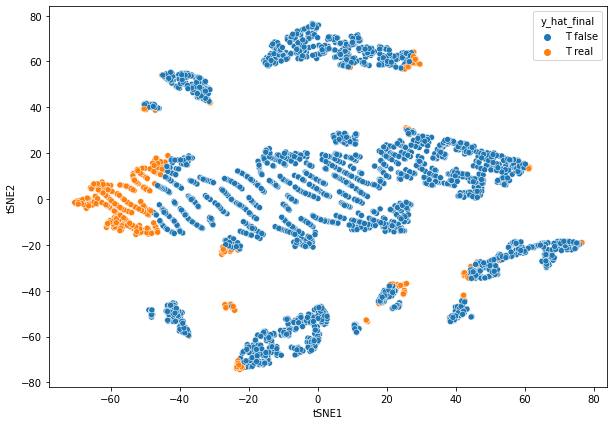

In [68]:
plt.figure(figsize=(10,7))
sn.scatterplot(data=df_tsne_final, x="tSNE1", y="tSNE2", hue="y_hat_final")
plt.show()

The final classifier performed very well and found almost exclusively T real reads on CT sites from WT sample. The number is however too much low. This could be due to, for instance, the silencing efficacy of APOBEC1 KO model. One good idea could be to train a similar model using only reads of in-vitro produced experiments with curlcakes sample from epinano experiments.